In [67]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *
from statistics import mean

Nchunk = 20
trials = 1e4
directory = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/'
nfolders = ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/']
dfolders = ['tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/']
folders = nfolders + dfolders

print(dfolders, nfolders, folders)

['tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/'] ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/'] ['tesi_preliminary_nominal_noEBL/', 'tesi_preliminary_nominal_EBL/', 'tesi_preliminary_degraded_noEBL/', 'tesi_preliminary_degraded_EBL/']


In [68]:
for i, f in enumerate(folders):
    os.system('mkdir %s/png' %(directory+f))
    path = directory + f + 'run0406/run0406_ID000126/csv/'

    texp = [1,5,10,100]
    sigma = [5]
    chunk = [i+1 for i in range(Nchunk)]

    csvName = [[]*i for i in range(len(texp))]
    for i in range(len(chunk)) :  
        for j in range(len(texp)) :
            csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
            
    # merge files ---!
    csvMerged = []
    for j in range(len(texp)) :
        csvMerged.append('run0406_%ds.csv' %texp[j])

        fout = open(path+csvMerged[j],'w+')
        # first file ---!
        for line in open(path+csvName[j][0]):
            fout.write(line)
        # remaining files ---!    
        for i in range(len(chunk)-1):
            f = open(path+csvName[j][i+1])
            next(f) # skip the header ---!
            for line in f:
                 fout.write(line)
            f.close() 
        fout.close()

    print(csvMerged)
print('done')

['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
done


In [69]:
# reformat files ---!
#for f in csvMerged:
#    with open(path+f, 'r') as inp, open(path+f.replace('.csv', '_mod.csv'), 'w') as out:
#        writer = csv.writer(out)
#        for row in csv.reader(inp):
#            if len(row) == 6 and ('ID' in row[0] or '#' in row[0]):
#                writer.writerow(row)


#for index, f in enumerate(csvMerged):
#    csvMerged[index] = f.replace('.csv', '_mod.csv')
#print(csvMerged)

In [70]:
# data params ---!
threshold = 0.5
xlim=0.1
hist = False

# hist params ---!
Dwidth = 0.02
Dnbin = int(threshold / Dwidth)

# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')

In [106]:
# ------------------------------------------ plots ---!
def plottage(texp, ra, dec, pos, mean_ra, mean_dec, mean_pos, trueRA, trueDEC, png_path, ltexp=True, hist=True):
    '''
    All parameter histograms.
    '''

    c = ['darkgreen', 'red', 'navy', 'gold']
    alpha = 0.3
    
    # conf intervals params ---!
    nstd = [1,2,3,5]
    conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
    # img params ---!
    CI_colors = ['k', 'r', 'g', 'w']
    if ltexp:
        leglabel = ['texp=%ds' %texp[i] for i in range(len(texp))]
    else:
        leglabel = ['Nominal, EBL unabsorbed', 'Nominal, EBL absorbed', 
                    'Degraded, EBL unabsorbed', 'Degraded, EBL absorbed']

    # DETECTION 1D ---!
    fig, ax = hist1d_gauss(ra, mean=None, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                           color=c, alpha=alpha, hist=hist, ax_thresh=xlim,
                           title='detected RA distribution', leglabel=leglabel,
                           xlabel='RA (deg)', ylabel='counts density',
                           filename=png_path+'_detRA_h%s.png' %str(hist))   
    plt.show()
    plt.close()

    fig, ax = hist1d_gauss(dec, mean=None, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                           threshold=threshold, color=c, alpha=alpha, ax_thresh=xlim,
                           title='detected DEC distribution', hist=hist, leglabel=leglabel,
                           xlabel='DEC (deg)', ylabel='counts density',
                           filename=png_path+'_detDEC_h%s.png' %str(hist)) 
    plt.show()
    plt.close()

    fig, ax = hist1d_rayleigh(pos, mean=None, rayleigh_prms={'loc':None, 'scale':None}, 
                              threshold=threshold, nbin=Dnbin, width=Dwidth, ax_thresh=xlim,
                              color=c, alpha=alpha, hist=hist, leglabel=leglabel, 
                              title='detected $\\Delta \\Theta$ distribution',
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename=png_path+'_detPOS_h%s.png' %str(hist))
    plt.show()
    plt.close()

def plottage2(texp, ra, dec, std_ra, std_dec, trueRA, trueDEC, png_path):
    '''
    Positioning map like poster (with mean and std).
    '''

    c = ['navy', 'firebrick']
    alpha = 0.8    
    # img params ---!
    figsize=(20, 16)
    fontsize=30
    leglabel = ['nominal', 'degraded']
    leglabel2 = ['texp=%ds' %texp[i] for i in range(len(texp))]
    markers = ['P', 'X', 'o', 's']

    
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    for i in range((len(texp))) :
        plt.scatter(ra[0][i], dec[0][i], s=1e3, marker=markers[i], alpha=alpha, edgecolors=c[0], 
                    facecolors='none', label=leglabel2[i])    
        plt.errorbar(ra[0][i], dec[0][i], xerr=std_ra[0][i], yerr=std_dec[0][i], color=c[0], alpha=alpha)
        plt.scatter(ra[1][i], dec[1][i], s=1e3, marker=markers[i], alpha=alpha, edgecolors=c[1], 
                    facecolors='none')    
        plt.errorbar(ra[1][i], dec[1][i], xerr=std_ra[1][i], yerr=std_dec[1][i], color=c[1], alpha=alpha)

    plt.scatter(trueRA, trueDEC, s=5e2, marker='*', label='true position', alpha=1, c='k')
    plt.axis([trueRA-0.08, trueRA+0.08, trueDEC-0.08, trueDEC+0.08])
    plt.title('source localisation (10$^4$ trials)', fontsize=fontsize)
    plt.xlabel('RA (deg)', fontsize=fontsize)
    plt.ylabel('DEC (deg)', fontsize=fontsize)
    legend1 = plt.legend(loc=4, fontsize=fontsize)
    ax.add_artist(legend1)

    custom_lines = [Line2D([0], [0], color=c[0], lw=1),
                    Line2D([0], [0], color=c[1], lw=1),
                    Line2D([0], [0], color='k', lw=1)]

    legend2 = plt.legend(custom_lines, ['nominal', 'degraded', 'true'], loc=2, fontsize=fontsize)
    ax.add_artist(legend2)
    # save only subplot with padding
    #plt.grid()
    plt.savefig(png_path+'_posErr_nomVSdeg.png')
    plt.show()
    plt.close()
    
def plottage3(texp, pos, std_pos, png_path):
    '''
    Positioning map like poster (with mean and std).
    '''

    alpha = 0.8
    # img params ---!
    figsize=(20, 16)
    fontsize=30
    leglabel = ['nominal, EBL unabsorbed', 'nominal, EBL absorbed', 
                'degraded, EBL unabsorbed', 'degraded, EBL absorbed']
    index=[3,2,1,0]
    markers = ['P', 'X', 'o', 's']
    c = ['b', 'r', 'g', 'orange']

    
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    for i in range((len(pos))) :
        plt.fill_between(np.array(texp),0.0, 
                         np.array(pos[index[i]])+np.array(std_pos[index[i]]), color=c[i], alpha=alpha)
    for i in range((len(pos))) :
        plt.plot(texp, pos[index[i]], lw=3, alpha=1, c=c[i])
        plt.scatter(texp, pos[index[i]], label=leglabel[index[i]], marker=markers[i], alpha=alpha, 
                    edgecolors='k', facecolors=c[i], s=5e2)

    plt.title('$\Delta$$\Theta$ versus $t_{exp}$ (10$^4$ trials)', fontsize=fontsize)
    plt.xlabel('$t_{exp}$ (s)', fontsize=fontsize)
    plt.ylabel('$\Delta$$\Theta$ (deg)', fontsize=fontsize)
    legend1 = plt.legend(loc=0, fontsize=fontsize)
    ax.add_artist(legend1)
    plt.savefig(png_path+'_distVStexp.png')
    plt.show()
    plt.close()

def mappage(ra, dec, pos, trueRA, trueDEC, texp, wbin=Dwidth, trials=trials, treshold=threshold):
    '''
    Positioning map 2d (Gauss & Rayleigh region of confidence).
    '''

    fig, ax = hist2d_gauss_CI(ra, dec, nbin=None, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
                              threshold=threshold, colors=('k', 'r', 'orange', 'm'), 
                              ax_thresh=xlim, xlabel='RA (deg)', ylabel='DEC (deg)', show=True, 
                              title='localisation of source', interp=None,
                              filename=png_path + 'texp%ds_hist2d_CIgauss_map.png' %texp)

    fig, ax = hist2d_rayleigh_CI(ra, dec, nbin=None, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
                                 threshold=threshold, colors=('k', 'r', 'orange', 'm'), 
                                 rayleigh_prms={'loc':0, 'scale':pos},
                                 ax_thresh=xlim, xlabel='RA (deg)', ylabel='DEC (deg)', show=True, 
                                 title='localisation of source', interp=None,
                                 filename=png_path + 'texp%ds_hist2d_CIrayleigh_map.png' %texp)
    
#    fig, ax = hist2d_map(ra, dec, trials, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
#                         threshold=threshold, ax_thresh=threshold, xlabel='RA (deg)', ylabel='DEC (deg)',
#                         title='positioning probability map', filename=png_path + 'texp%ds_map_CIgauss.png', 
#                         if_CI='rayleigh', rayleigh={'loc':0, 'scale':pos}, smooth=True, show=True)
        
#    fig, ax = hist2d_map(ra, dec, trials, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
#                         threshold=threshold, ax_thresh=threshold, xlabel='RA (deg)', ylabel='DEC (deg)',
#                         title='positioning probability map', filename=png_path + 'texp%ds_map_CIrayleigh.png', 
#                         if_CI='gauss', smooth=True, show=True)



    
print('\n\nok')



ok


In [107]:
# no EBL (nom, deg) ---!
ra = [[33.057, 33.057, 33.057, 33.056], [33.057, 33.057, 33.057, 33.055]]
dec = [[-51.840, -51.841, -51.840, -51.840], [-51.840, -51.841, -51.841, -51.840]]
std_ra = [[0.045, 0.022, 0.016, 0.004], [0.045, 0.022, 0.016, 0.004]]
std_dec = [[0.028, 0.013, 0.011, 0.009], [0.028, 0.013, 0.011, 0.010]]
pos = [[0.021, 0.010, 0.008, 0.007], [0.028, 0.013, 0.010, 0.007]]
std_pos = [[0, 0, 0, 0], [0, 0, 0, 0]]
for j in range(len(ra)):
    for i in range(len(ra[j])):
        std_pos[j][i] = float(SkyCoord(ra = 0*u.deg, dec = 0*u.deg, frame='fk5').separation(
            SkyCoord(ra = std_ra[j][i]*u.deg, dec = std_dec[j][i]*u.deg, frame='fk5')).deg)

# EBL (nom, deg) ---!
ra2 = [[33.058, 33.057, 33.057, 33.055], [33.059, 33.057, 33.057, 33.056]]
dec2 = [[-51.840, -51.841, -51.841, -51.840], [-51.839, -51.841, -51.840, -51.841]]
std_ra2 = [[0.055, 0.025, 0.019, 0.007], [0.072, 0.036, 0.026, 0.012]]
std_dec2 = [[0.034, 0.016, 0.012, 0.010], [0.047, 0.022, 0.016, 0.010]]
pos2 = [[0.034, 0.016, 0.012, 0.008], [0.046, 0.022, 0.016, 0.008]]
std_pos2 = [[0, 0, 0, 0], [0, 0, 0, 0]]
for j in range(len(ra)):
    for i in range(len(ra[j])):
        std_pos2[j][i] = float(SkyCoord(ra = 0*u.deg, dec = 0*u.deg, frame='fk5').separation(
            SkyCoord(ra = std_ra2[j][i]*u.deg, dec = std_dec2[j][i]*u.deg, frame='fk5')).deg)

print(std_pos, std_pos2)

[[0.05299999847921179, 0.025553864515851697, 0.019416487757952617, 0.009848857795115394], [0.05299999847921179, 0.025553864515851697, 0.019416487757952617, 0.01077032960672687]] [[0.06466064989564946, 0.029681643885636416, 0.022472204936801136, 0.012206555595353597], [0.08598254960879466, 0.04219004546463717, 0.030528674757153193, 0.015620499305010594]]


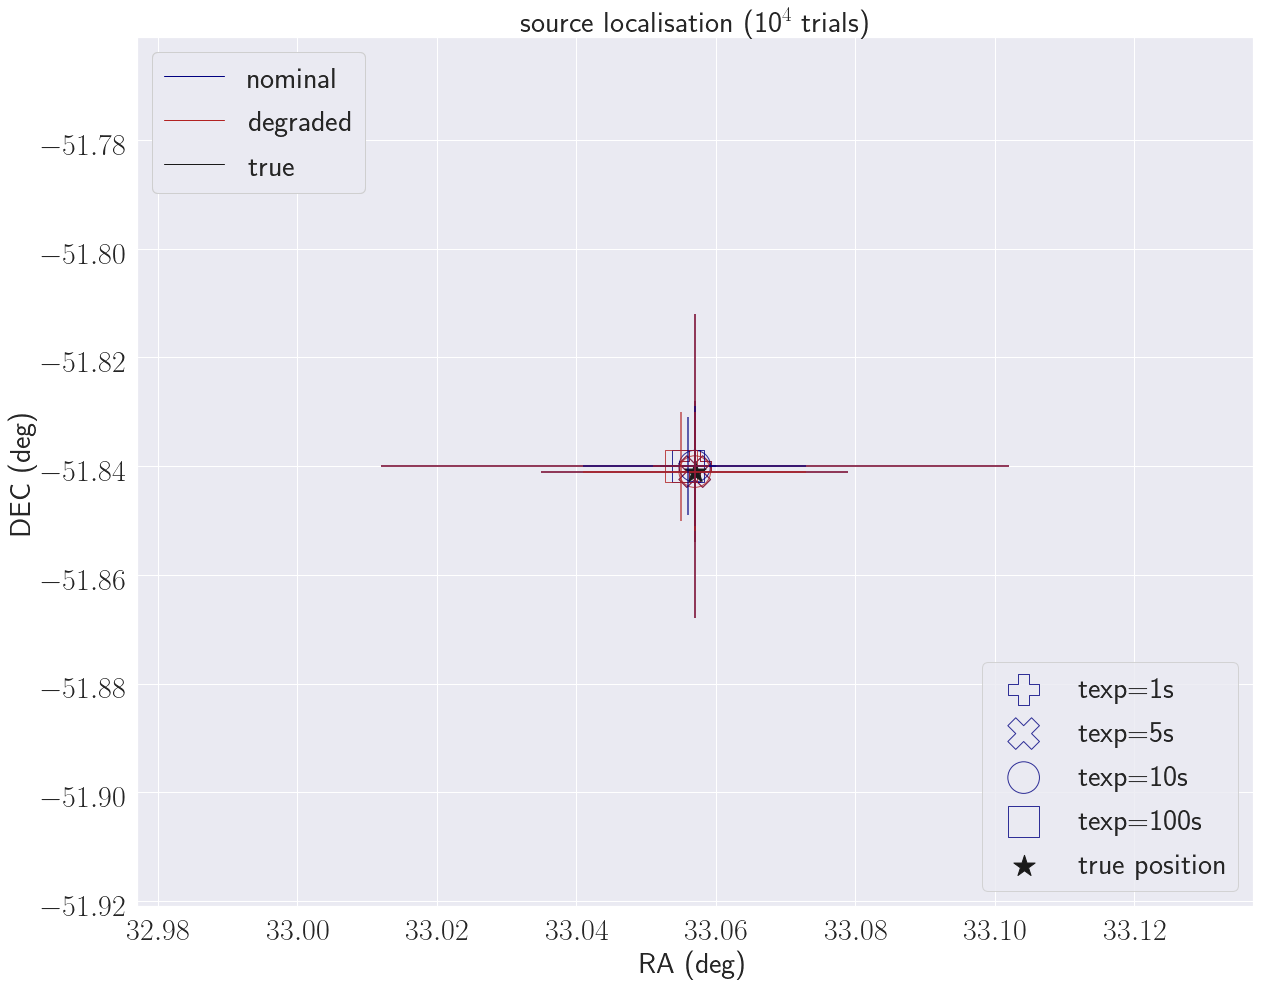

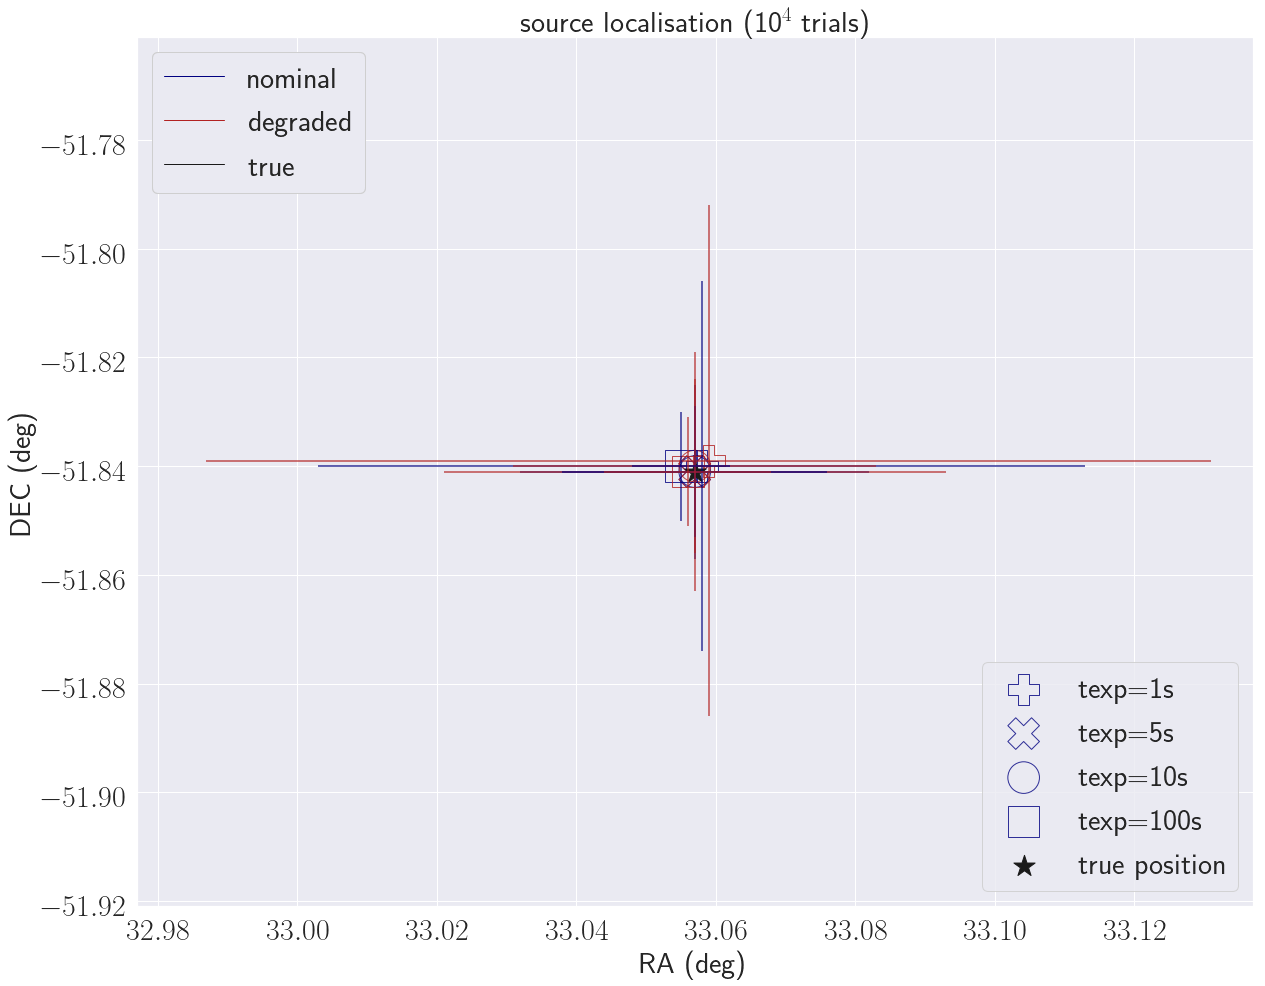

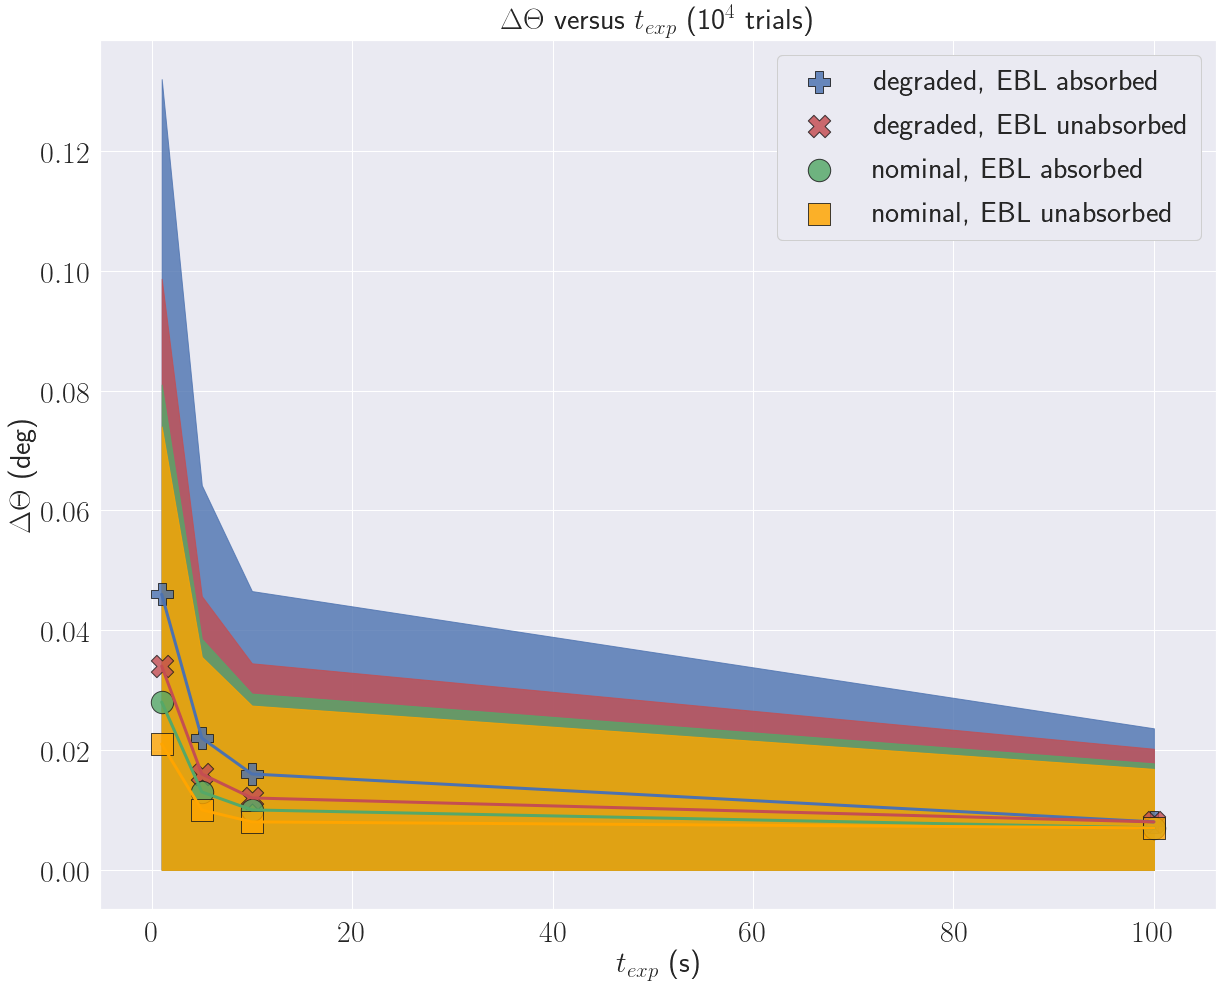

In [108]:
png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/png/'
if not os.path.isdir(png_path):
    os.system('mkdir ' + png_path)


plottage2(texp, ra, dec, std_ra, std_dec, trueRA, trueDEC, png_path+'EBL')
plottage2(texp, ra2, dec2, std_ra2, std_dec2, trueRA, trueDEC, png_path+'noEBL')
plottage3(texp, pos+pos2, std_pos+std_pos2, png_path+'all')

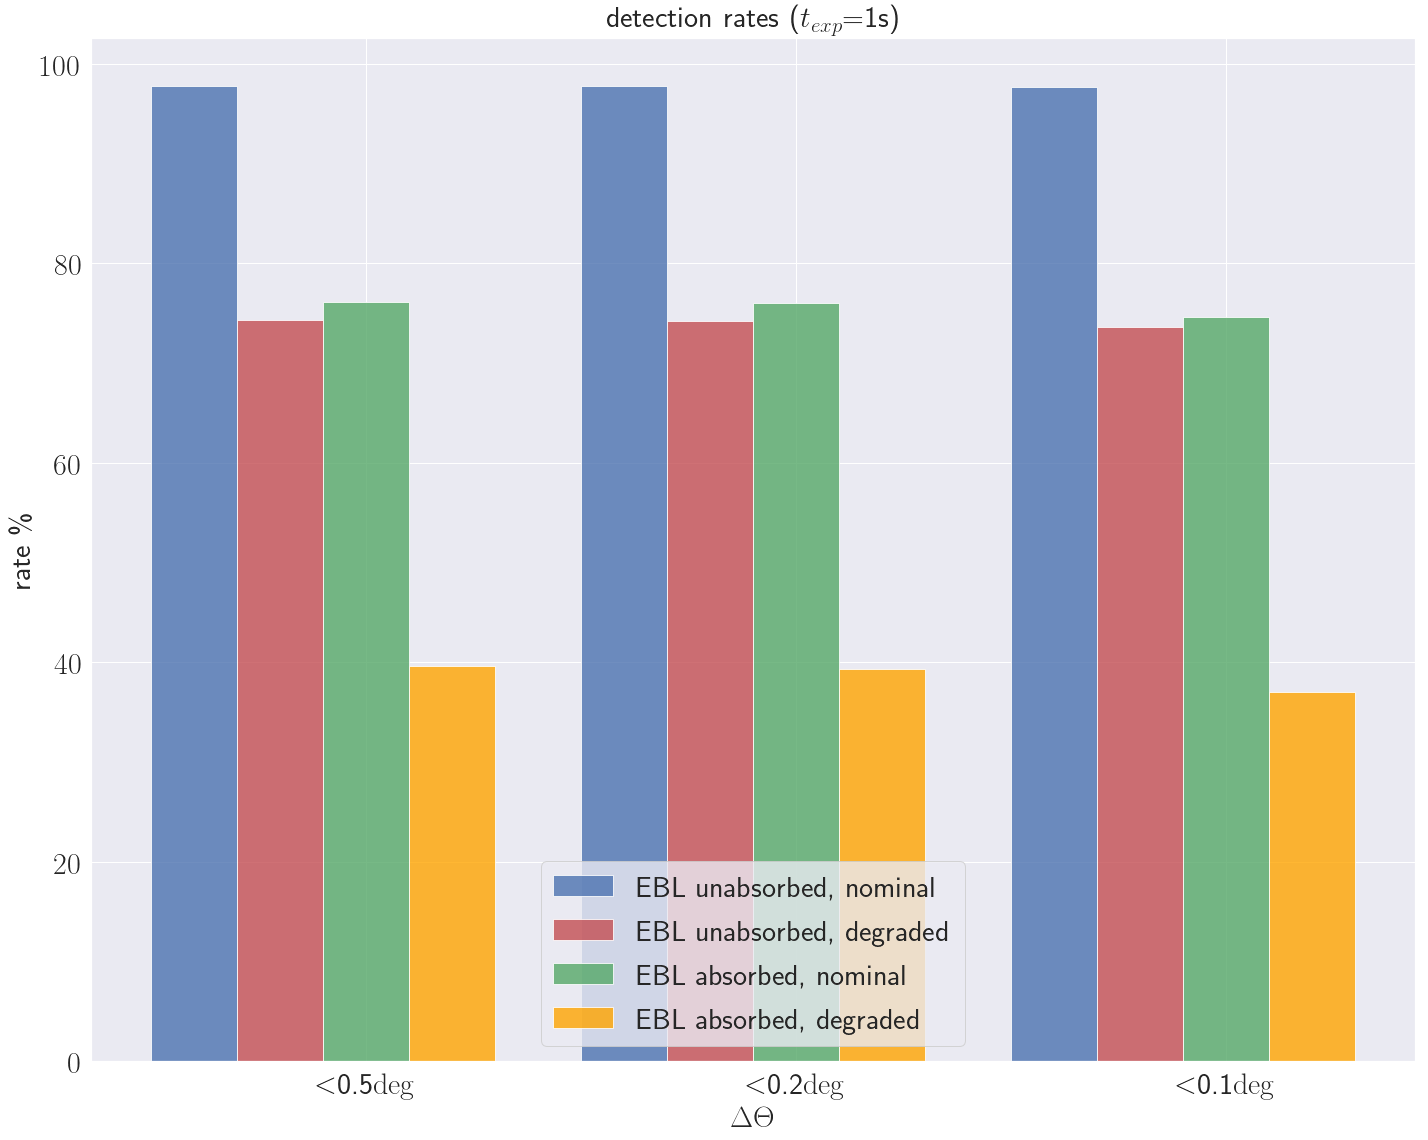

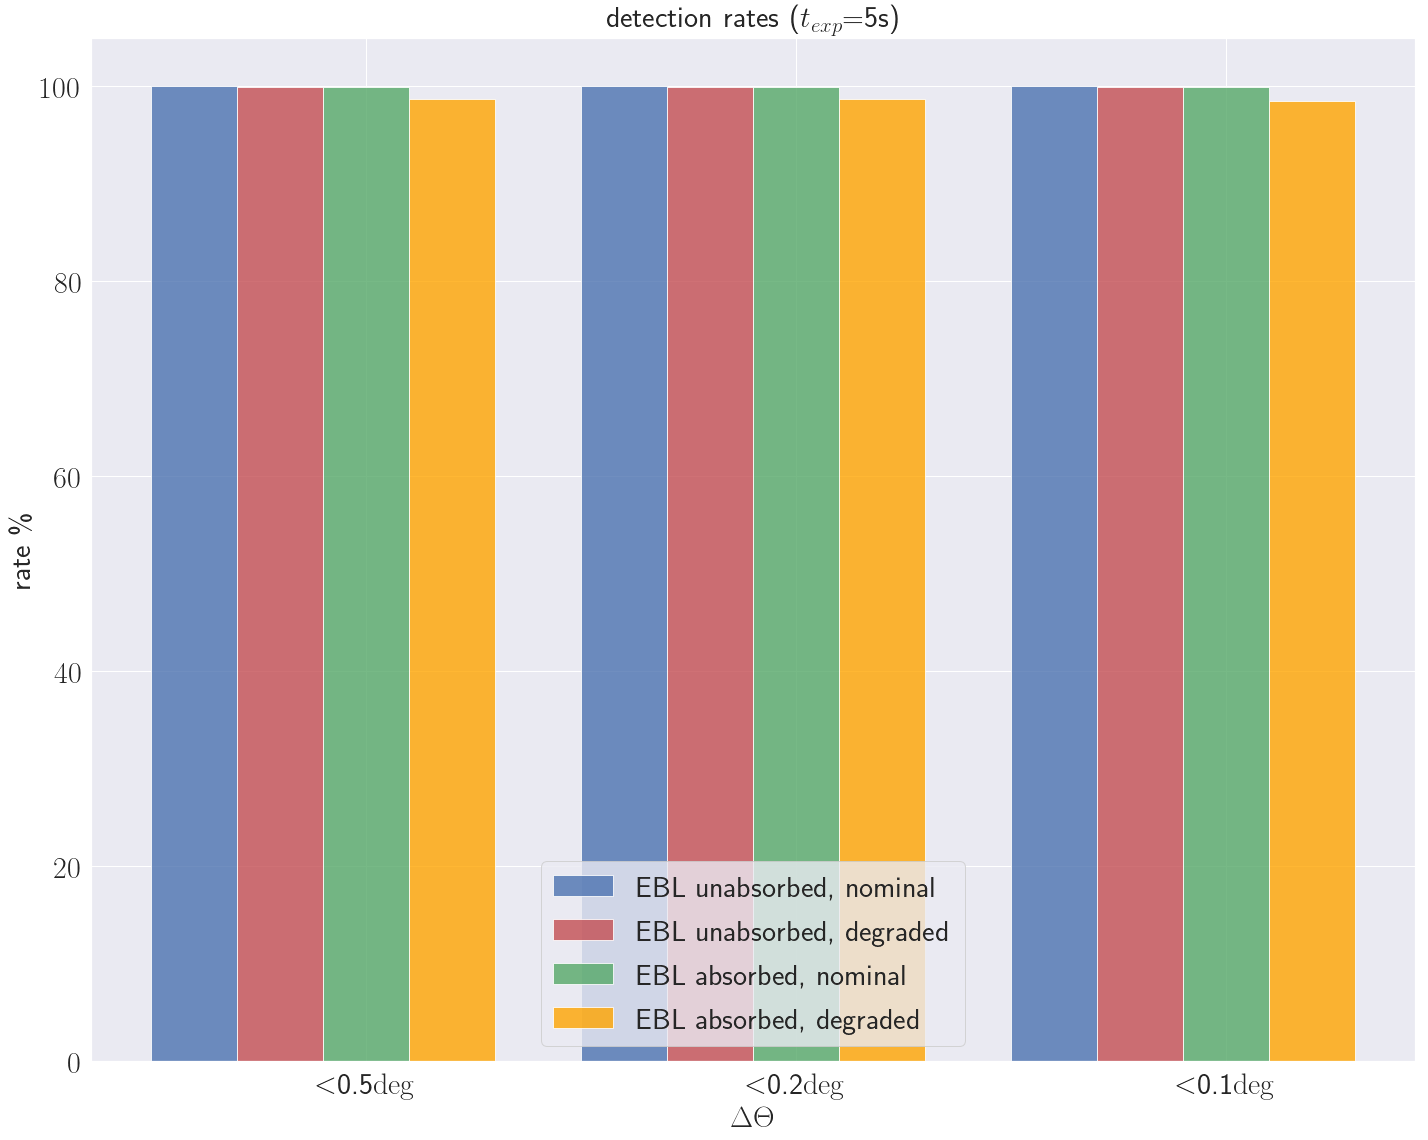

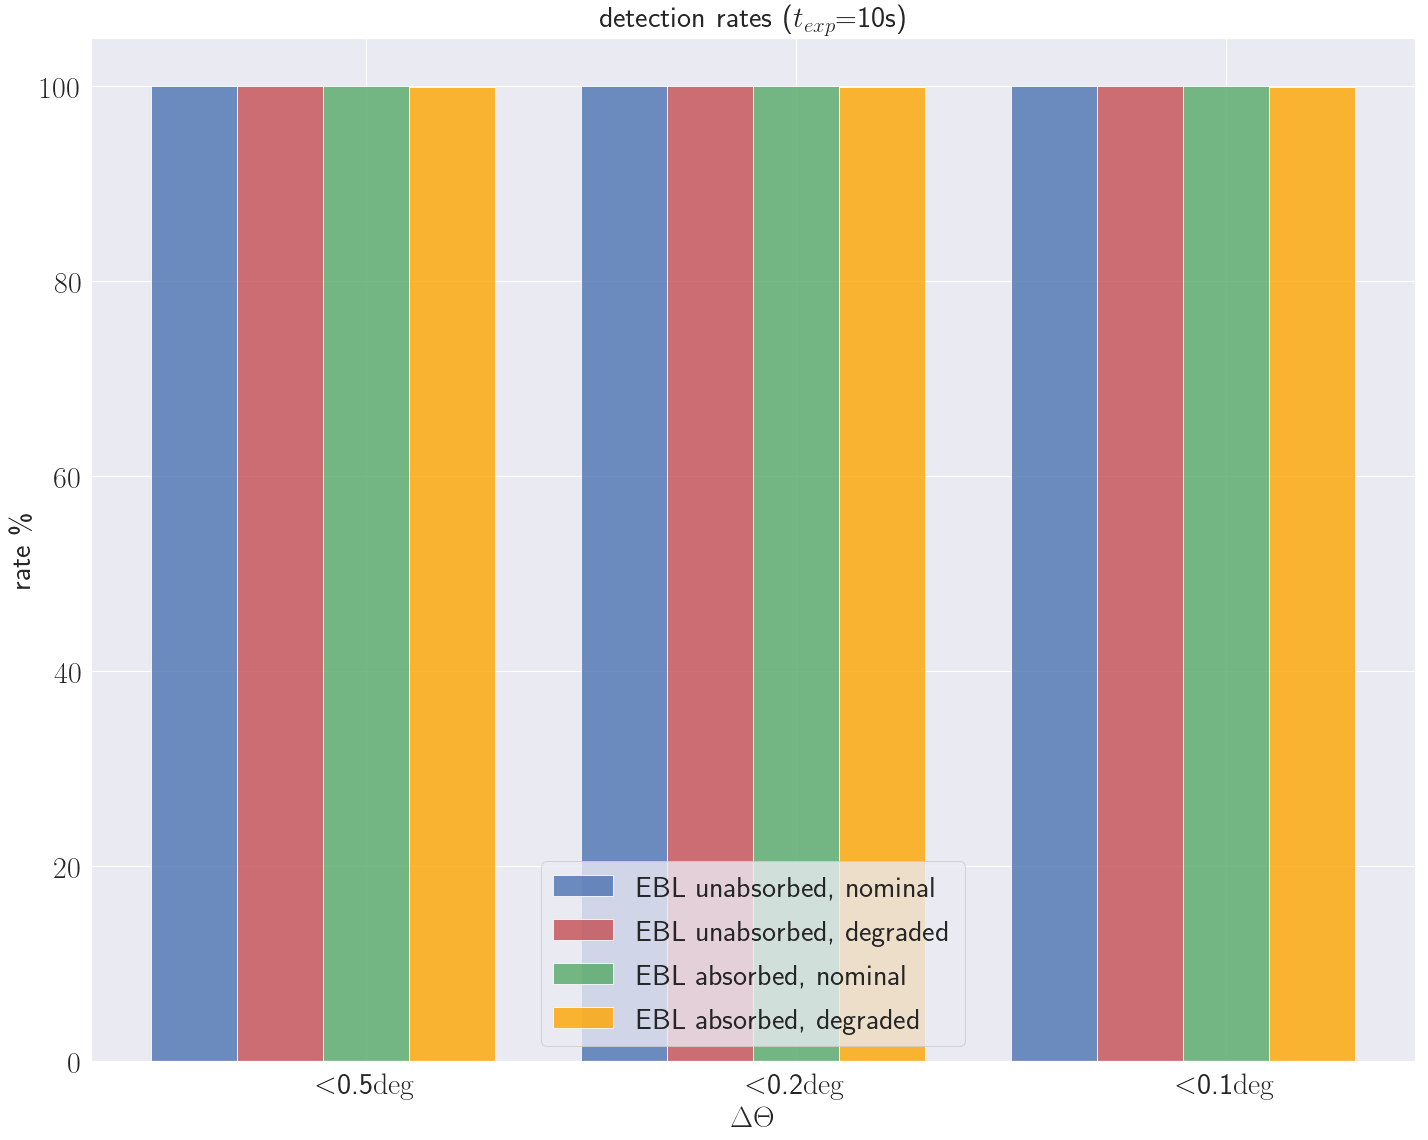

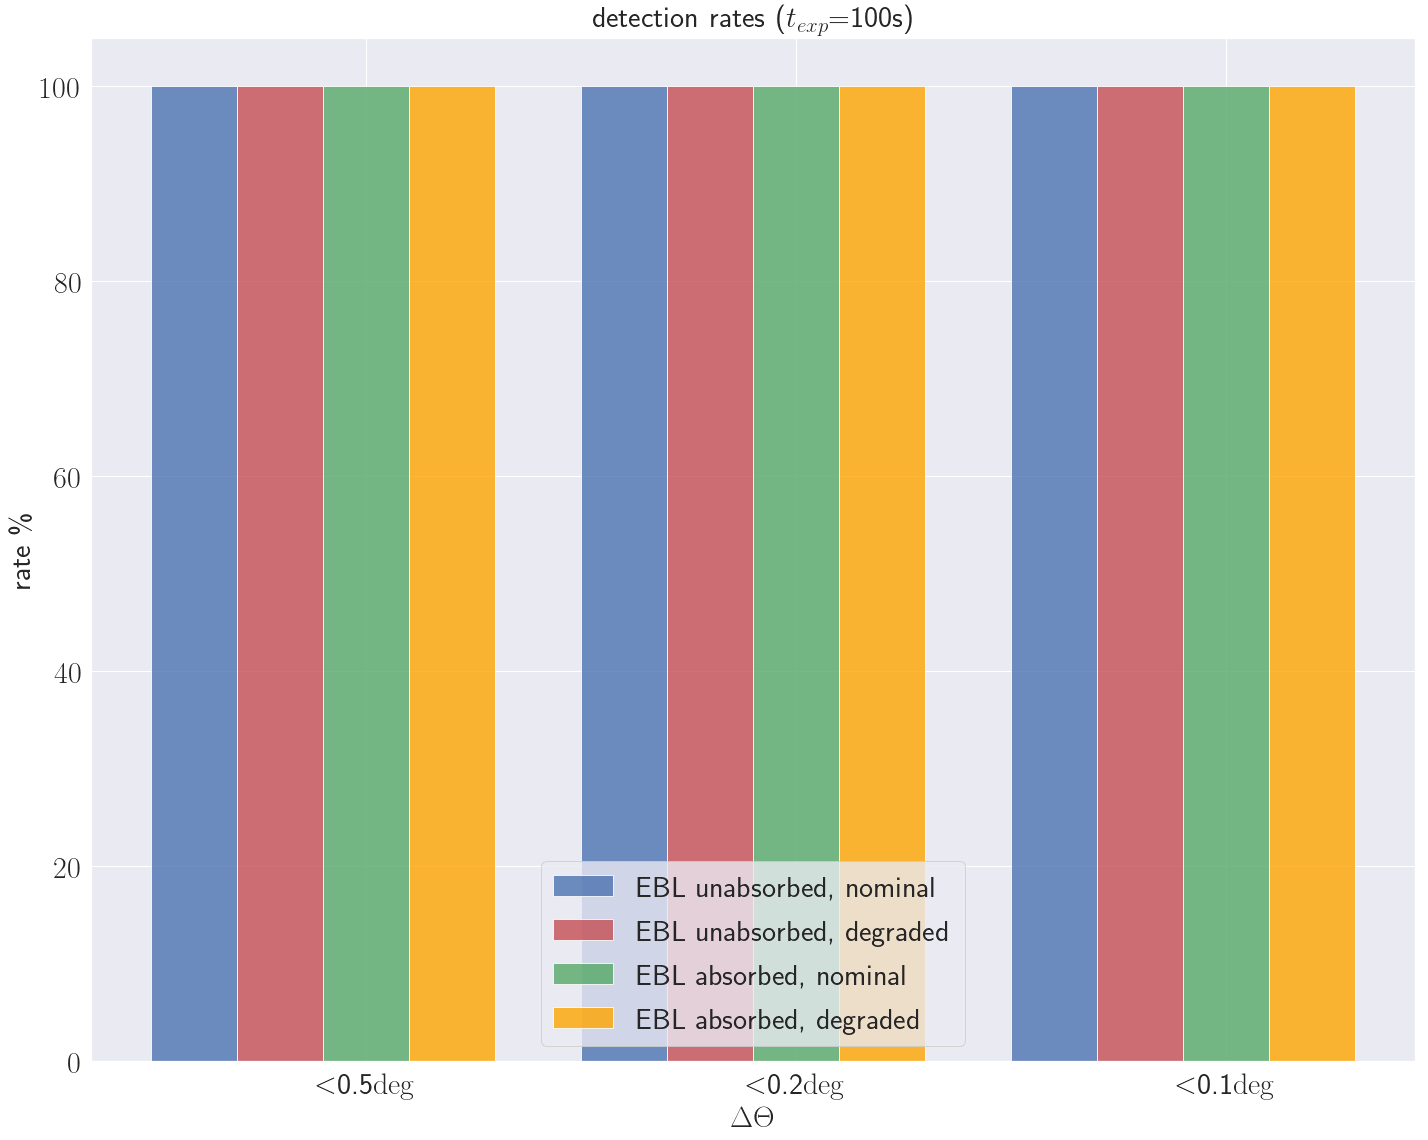

In [104]:
# data to plot
n_groups = 4

# rates 1, 5, 10, 100s (theta < [0.5, 0.2, 0.1]) ---!
noEBLnom = [[97.71, 97.71, 97.62], [100, 100, 100], [100, 100, 100], [100, 100, 100]]
noEBLdeg = [[74.27, 74.21, 73.55], [99.99, 99.99, 99.99], [100, 100, 100], [100, 100, 100]]
EBLnom = [[76.13, 75.97, 74.55], [99.99, 99.99, 99.99], [100, 100, 100], [100, 100, 100]]
EBLdeg = [[39.64, 39.27, 36.98], [98.69, 98.69, 98.53], [99.96, 99.96, 99.95], [100, 100, 100]]

# create plot
bar_width = 0.2
bar_sep = 1
opacity = 0.8
figsize=(20, 16)
fontsize=30

index = [np.arange(3), np.arange(3)+bar_width, np.arange(3)+bar_width*2, np.arange(3)+bar_width*3]

for n in range(len(texp)):
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    rects1 = plt.bar(index[0], noEBLnom[n], bar_width,
                     alpha=opacity, color='b', label='EBL unabsorbed, nominal')
    rects1 = plt.bar(index[1], noEBLdeg[n], bar_width,
                     alpha=opacity, color='r', label='EBL unabsorbed, degraded')
    rects2 = plt.bar(index[2], EBLnom[n], bar_width,
                     alpha=opacity, color='g', label='EBL absorbed, nominal')
    rects3 = plt.bar(index[3], EBLdeg[n], bar_width,
                     alpha=opacity, color='orange', label='EBL absorbed, degraded')
    
#    for i in range(3):
#        plt.text(index[0][i]-0.1, noEBLnom[n][i]-5, '%.2f' %noEBLnom[n][i]+'\%', 
#                 fontsize=fontsize*1.5, color='k')
#        plt.text(index[1][i]-0.1, noEBLdeg[n][i]-15, '%.2f' %noEBLdeg[n][i]+'\%', 
#                 fontsize=fontsize*1.5, color='k')
#        plt.text(index[2][i]-0.1, EBLnom[n][i]-5, '%.2f' %EBLnom[n][i]+'\%', 
#                 fontsize=fontsize*1.5, color='k')
#        plt.text(index[3][i]-0.1, EBLdeg[n][i]-15, '%.2f' %EBLdeg[n][i]+'\%', 
#                 fontsize=fontsize*1.5, color='k')

    #rects2 = plt.bar(index + bar_width, noEBLnom[1]+noEBLdeg[1]+EBLnom[1]+EBLdeg[1], bar_width,
    #                 alpha=opacity, color='g', label='Guido')

    plt.xlabel('$\Delta$$\Theta$', fontsize=fontsize)
    plt.ylabel('rate \%', fontsize=fontsize)
    plt.title('detection rates ($t_{exp}$=%ds)' %texp[n], fontsize=fontsize)
    plt.xticks(index[1] + bar_width, ('$<$0.5$\deg$', '$<$0.2$\deg$', '$<$0.1$\deg$'))
    plt.legend(loc='lower center', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(png_path+'rates_texp%ds.png' %texp[n])
    plt.show()
    plt.close()


tesi_preliminary_nominal_noEBL/

================ texp = 1s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_1s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9965
! NaN DETECTION RATE : 0.3499999999999943 %
! DETECTION RATE : 99.65 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 97.71 %
~ ra det mean: 33.05757565415634 ra det std: 0.03284772282674553
~ dec det mean: -51.84021289999672 dec det std: 0.020851599060736945
~ pos det mean: 0.025218931531535805 pos det gamma: 0.02058429112982912


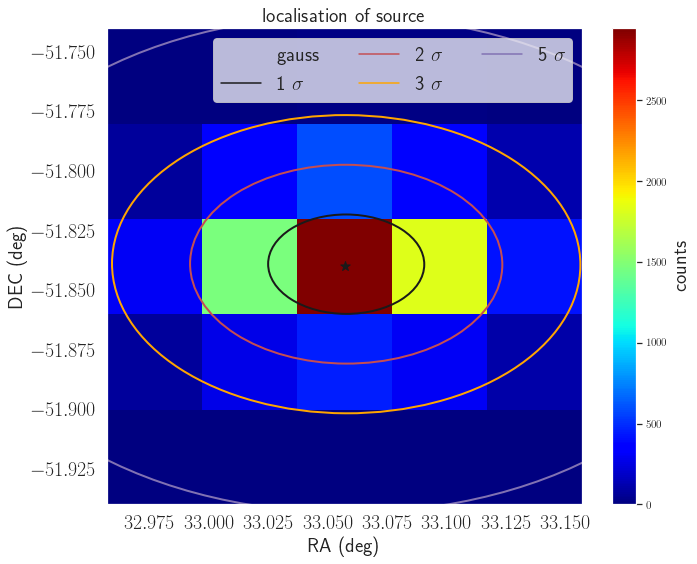

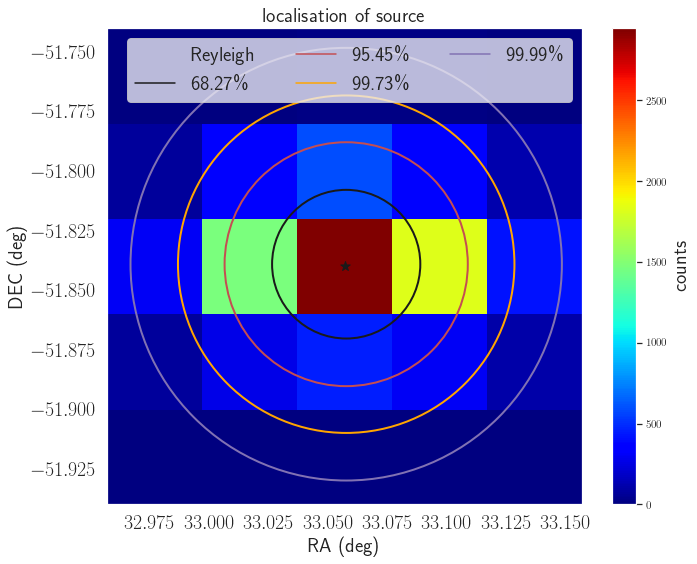


================ texp = 5s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_5s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.056904346820005 ra det std: 0.01578783960326459
~ dec det mean: -51.84072371452421 dec det std: 0.010827655706497796
~ pos det mean: 0.013351125473031087 pos det gamma: 0.01030698527665251


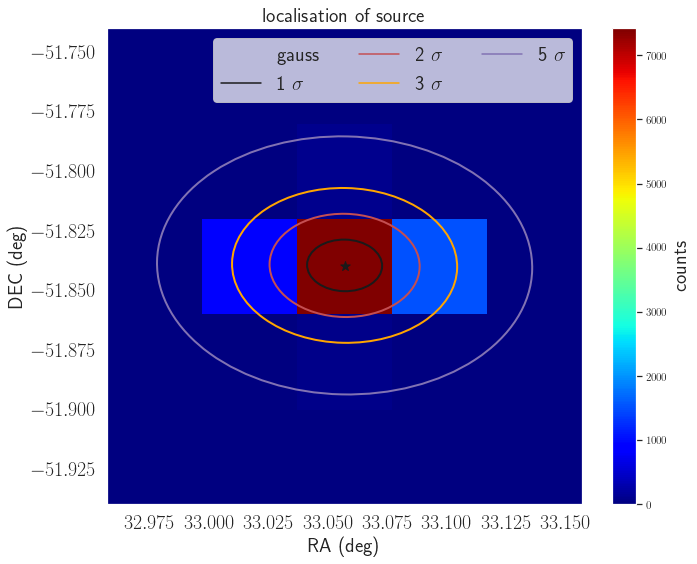

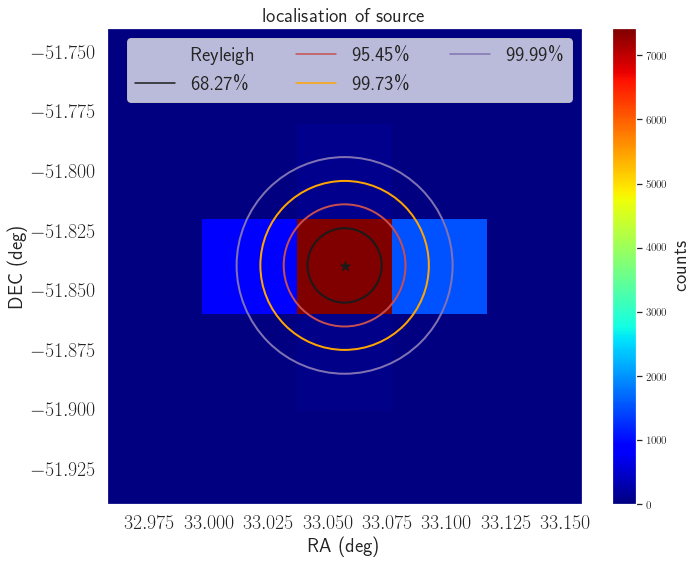


================ texp = 10s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_10s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05625065179873 ra det std: 0.010698592238719077
~ dec det mean: -51.84063060295181 dec det std: 0.010019454418006404
~ pos det mean: 0.011392407714010884 pos det gamma: 0.008498050566768747


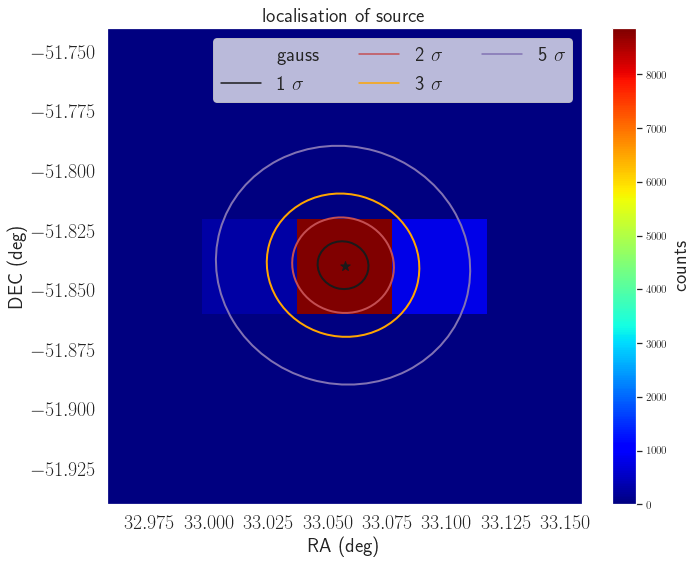

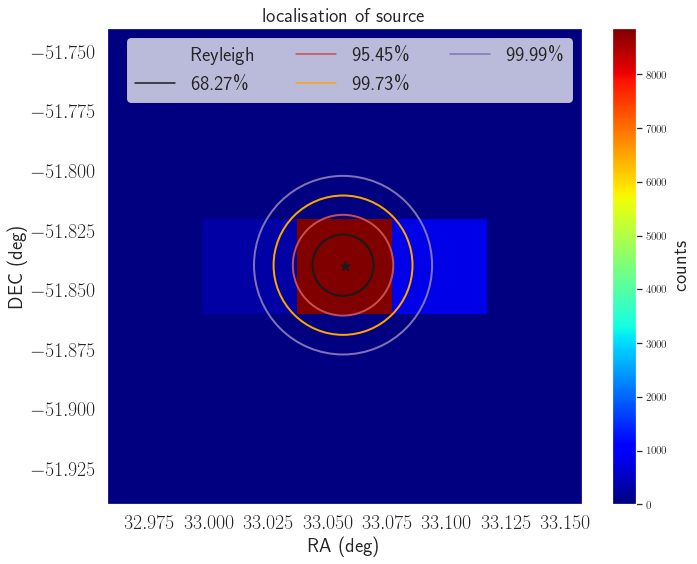


================ texp = 100s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_100s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05453778057833 ra det std: 0.0010736324613924986
~ dec det mean: -51.839836722227254 dec det std: 0.00983496447414015
~ pos det mean: 0.010018485560228536 pos det gamma: 0.0071005012700228595


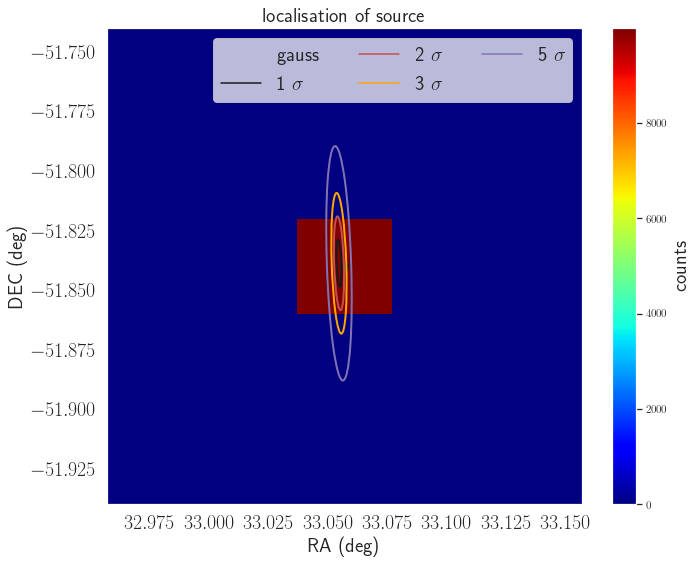

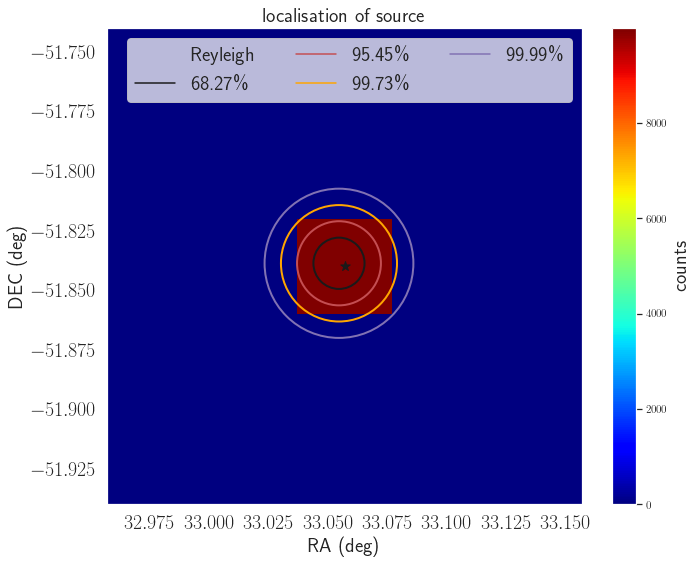

done plotting

tesi_preliminary_nominal_EBL/

================ texp = 1s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_1s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9543
! NaN DETECTION RATE : 4.569999999999993 %
! DETECTION RATE : 95.43 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 76.13 %
~ ra det mean: 33.058481312938724 ra det std: 0.055010918671458034
~ dec det mean: -51.839870390988104 dec det std: 0.03360955545597166
~ pos det mean: 0.039443884353464055 pos det gamma: 0.033816533474149126


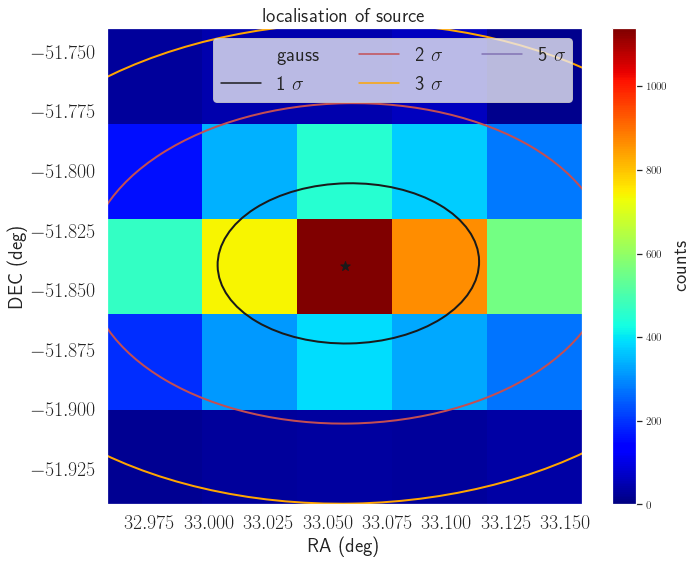

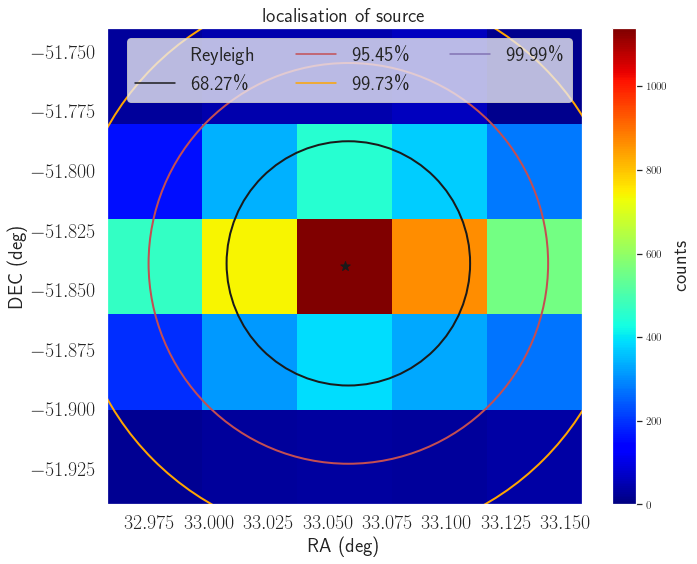


================ texp = 5s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_5s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9999
! NaN DETECTION RATE : 0.010000000000005116 %
! DETECTION RATE : 99.99 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.99 %
~ ra det mean: 33.05751658864937 ra det std: 0.025867216916258828
~ dec det mean: -51.84072901446484 dec det std: 0.015994003029397755
~ pos det mean: 0.020051069443456564 pos det gamma: 0.01599076500923886


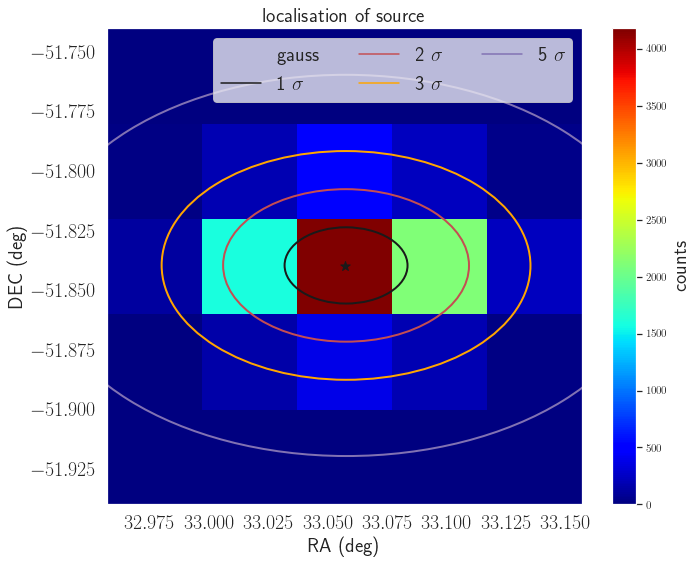

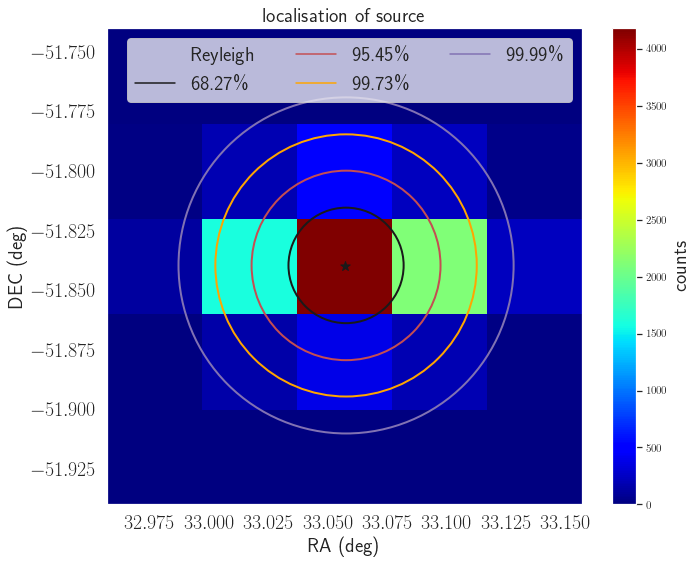


================ texp = 10s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_10s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.057158219738035 ra det std: 0.019193468797232216
~ dec det mean: -51.84086399472577 dec det std: 0.012040481108904709
~ pos det mean: 0.015252535527247733 pos det gamma: 0.0119504948717758


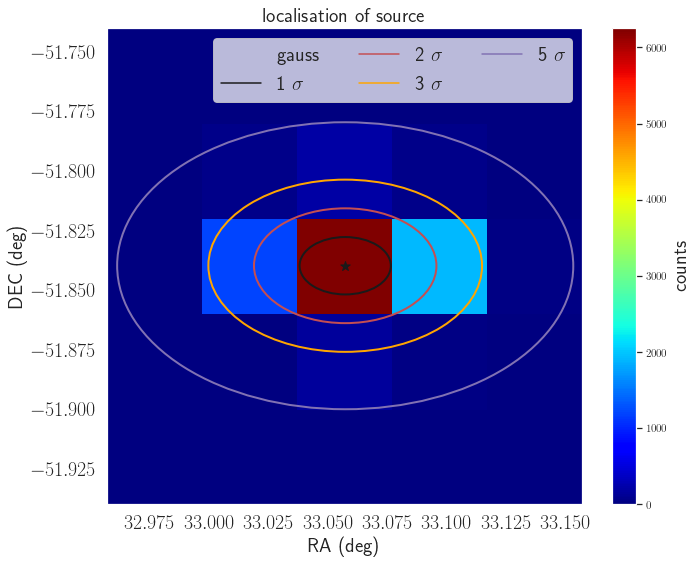

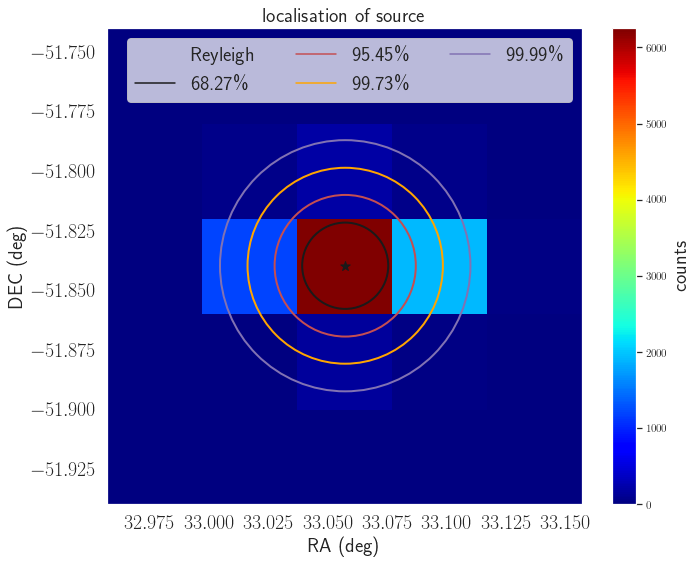


================ texp = 100s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_100s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05542795234129 ra det std: 0.0066324767387675974
~ dec det mean: -51.84042133547179 dec det std: 0.009925806620942421
~ pos det mean: 0.01052974350615409 pos det gamma: 0.0076351975470433245


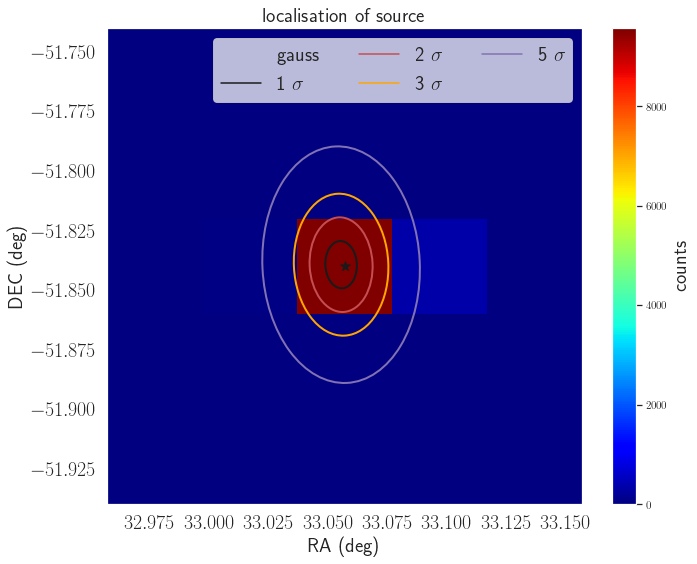

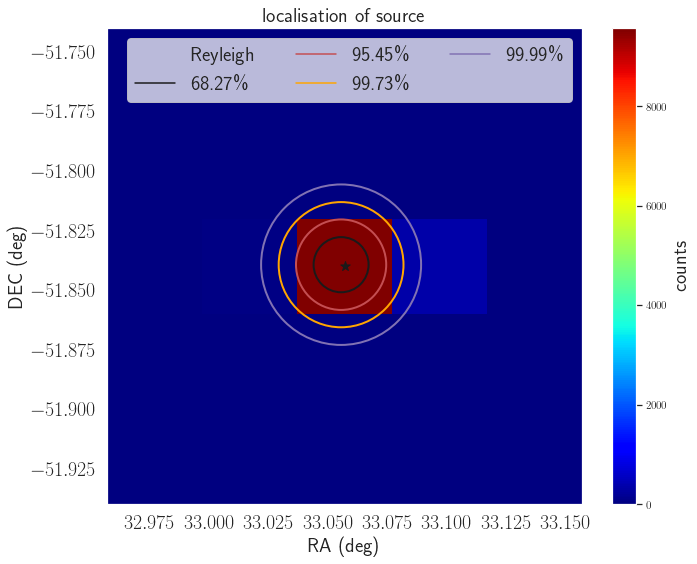

done plotting

tesi_preliminary_degraded_noEBL/

================ texp = 1s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_1s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9978
! NaN DETECTION RATE : 0.21999999999999886 %
! DETECTION RATE : 99.78 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 74.27 %
~ ra det mean: 33.05753004704624 ra det std: 0.045147058904487995
~ dec det mean: -51.84035594427709 dec det std: 0.02827552771256372
~ pos det mean: 0.03282233137789097 pos det gamma: 0.028092110366494765


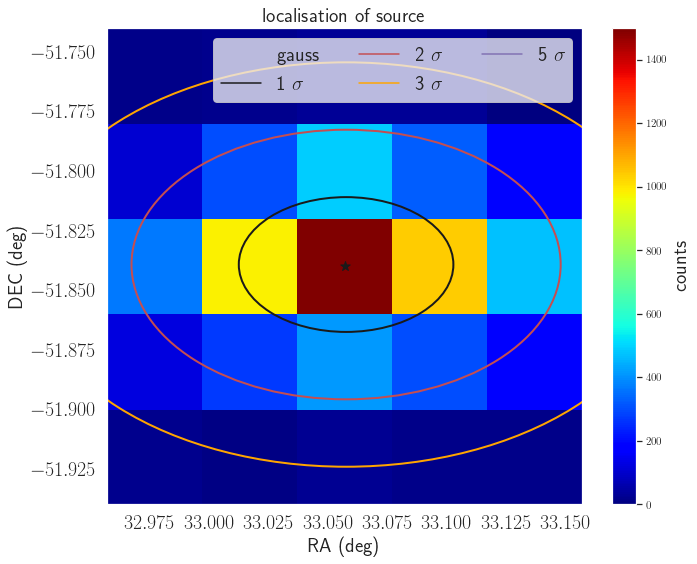

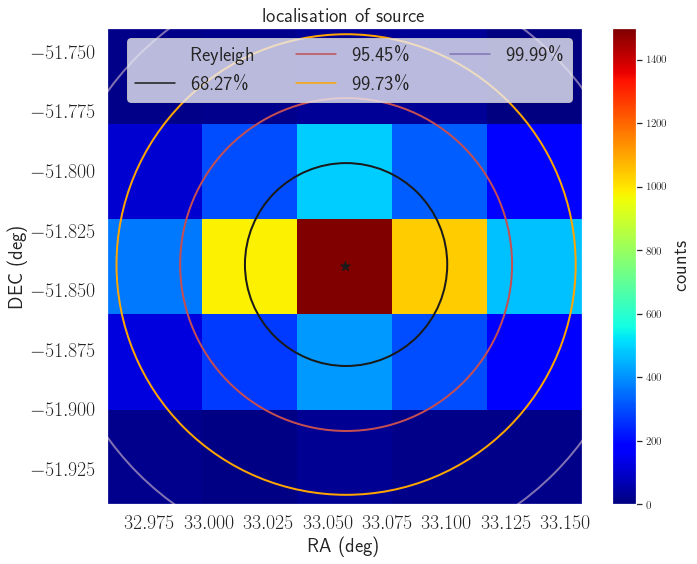


================ texp = 5s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_5s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.99 %
~ ra det mean: 33.05713557094892 ra det std: 0.02184739434628368
~ dec det mean: -51.84076270622719 dec det std: 0.01359403632313456
~ pos det mean: 0.01709168361305904 pos det gamma: 0.01354743652408479


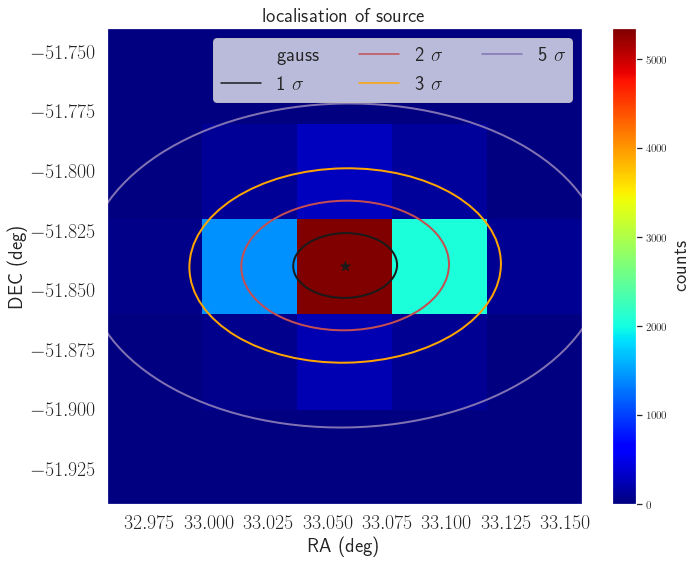

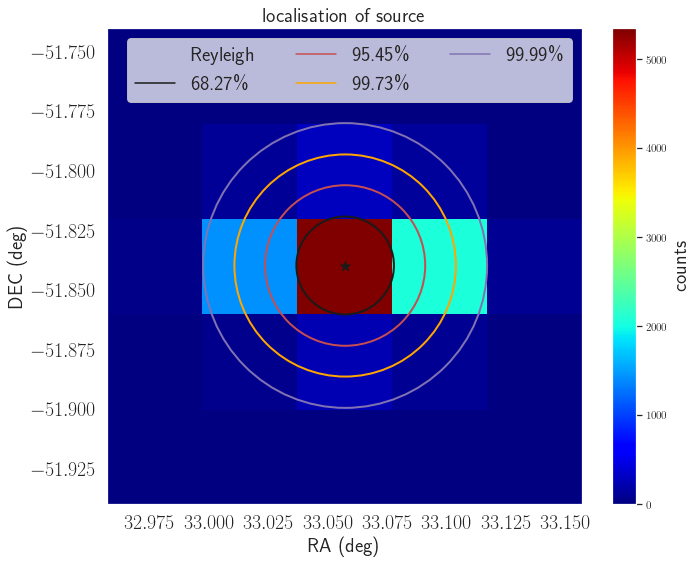


================ texp = 10s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_10s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05685942504236 ra det std: 0.01621820194829112
~ dec det mean: -51.84083425004082 dec det std: 0.010839100844365668
~ pos det mean: 0.013516615047310962 pos det gamma: 0.010438599999283668


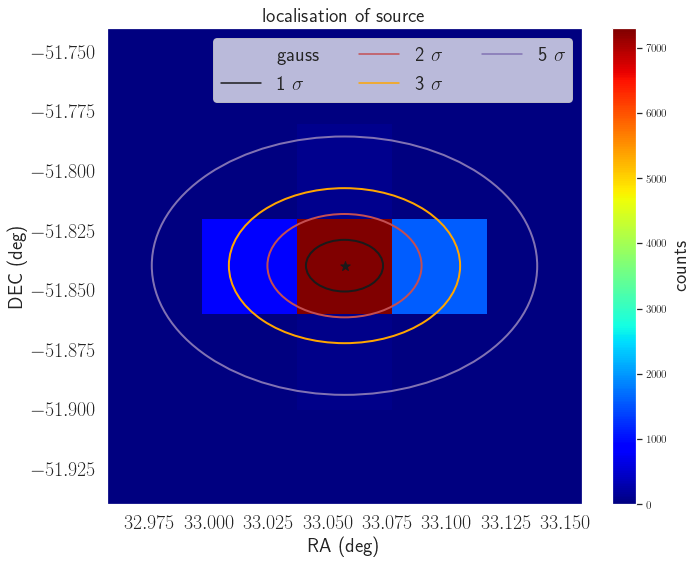

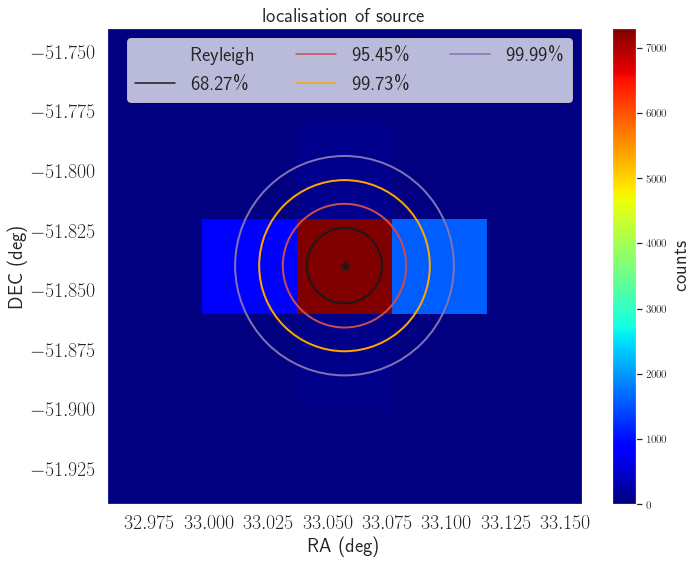


================ texp = 100s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_100s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05489303867169 ra det std: 0.004133561544841226
~ dec det mean: -51.84029823232279 dec det std: 0.009907912220901404
~ pos det mean: 0.010219650460619277 pos det gamma: 0.007310143401388814


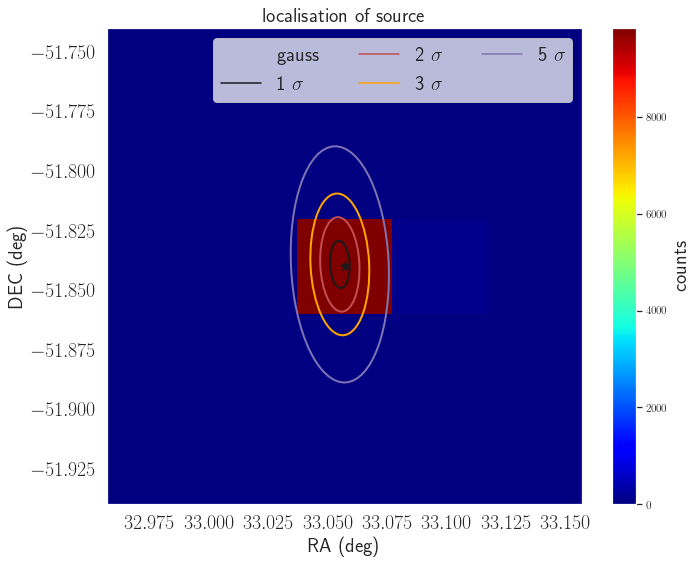

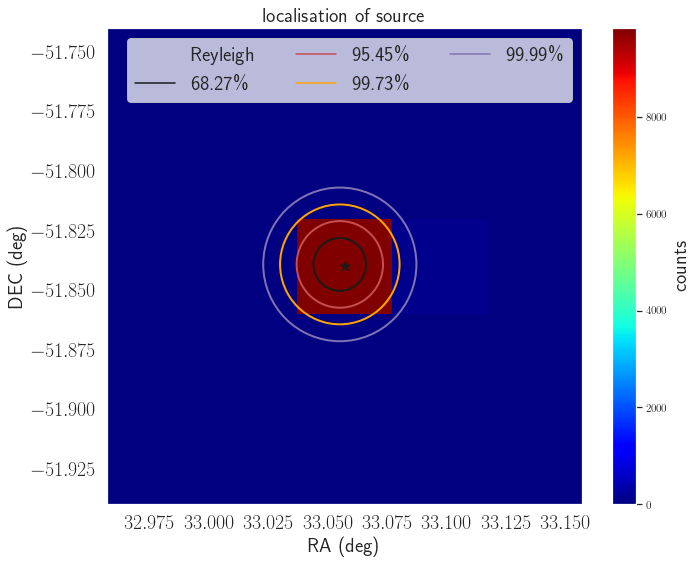

done plotting

tesi_preliminary_degraded_EBL/

================ texp = 1s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_1s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9924
! NaN DETECTION RATE : 0.7600000000000051 %
! DETECTION RATE : 99.24 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 39.64 %
~ ra det mean: 33.05903047865634 ra det std: 0.07210368585204463
~ dec det mean: -51.83950648005964 dec det std: 0.04748175151579654
~ pos det mean: 0.05007348713416708 pos det gamma: 0.04606148655914511


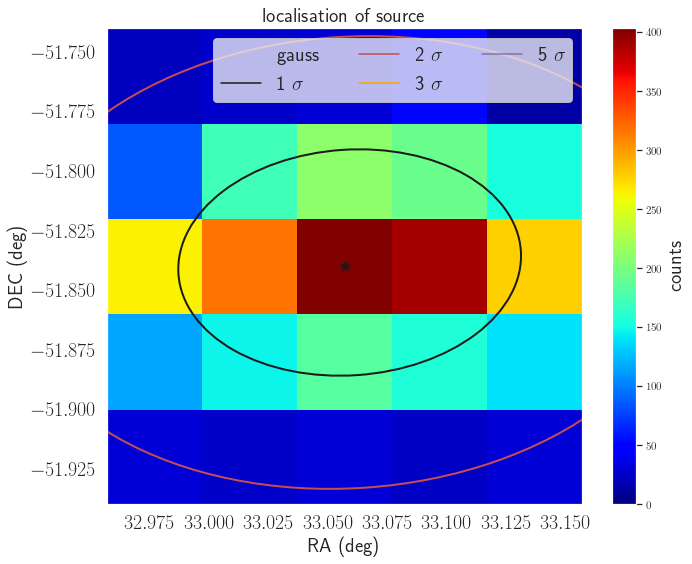

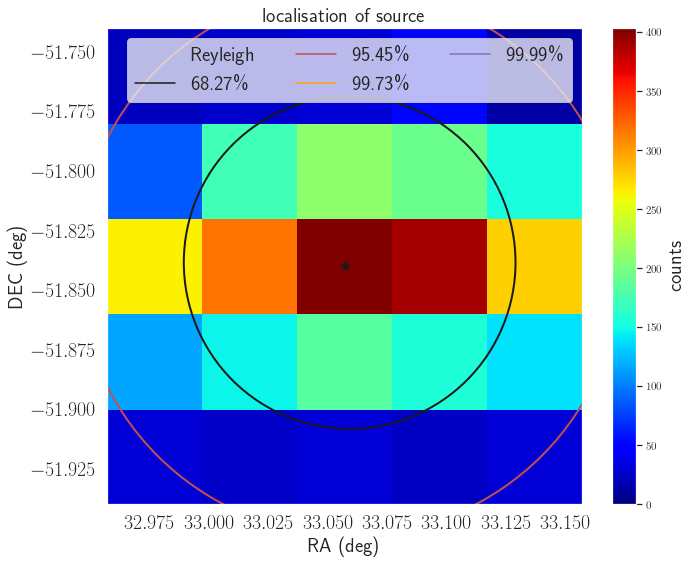


================ texp = 5s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_5s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9923
! NaN DETECTION RATE : 0.7700000000000102 %
! DETECTION RATE : 99.22999999999999 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 98.69 %
~ ra det mean: 33.05725676613933 ra det std: 0.036019363596991566
~ dec det mean: -51.840610784546975 dec det std: 0.022288039045893028
~ pos det mean: 0.027417974070940456 pos det gamma: 0.022273165191241263


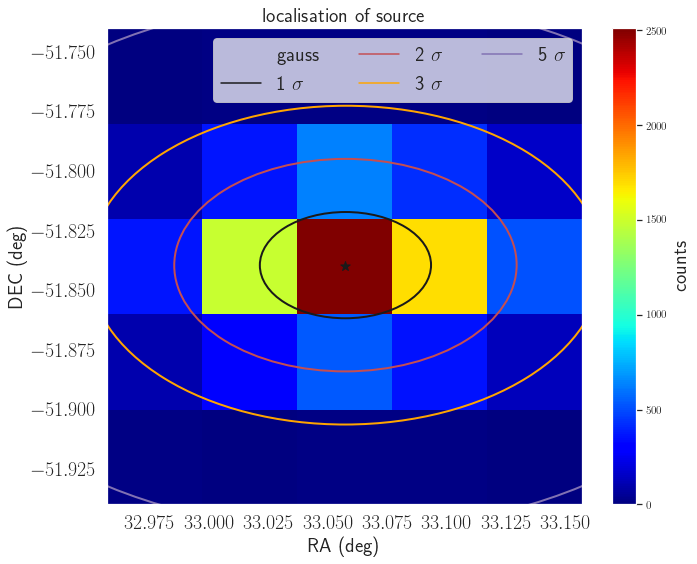

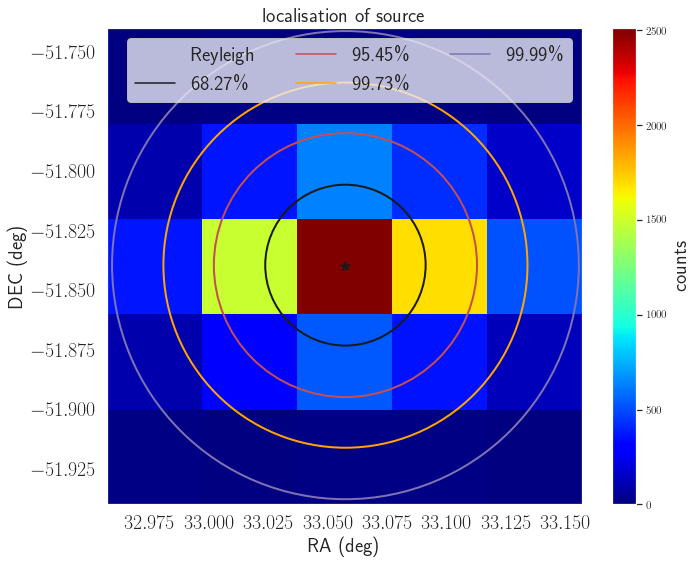


================ texp = 10s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_10s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.96000000000001 %
~ ra det mean: 33.057366186786396 ra det std: 0.026473733625245344
~ dec det mean: -51.84055943092667 dec det std: 0.016348993160070248
~ pos det mean: 0.020403906088126002 pos det gamma: 0.016356667831011872


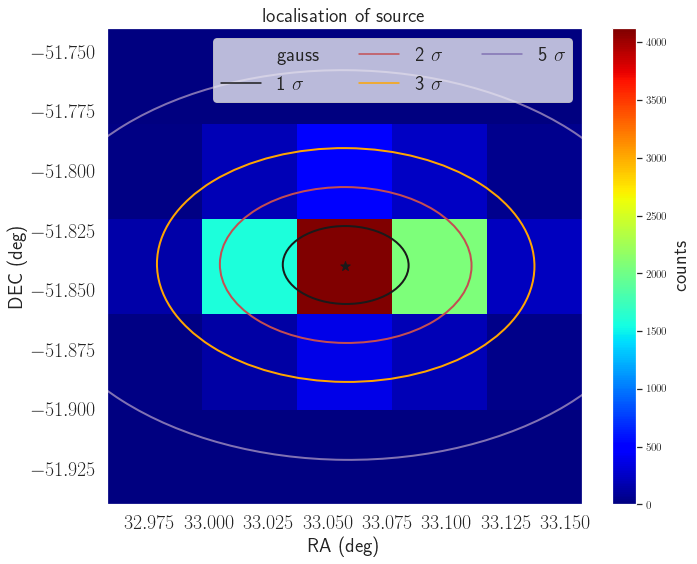

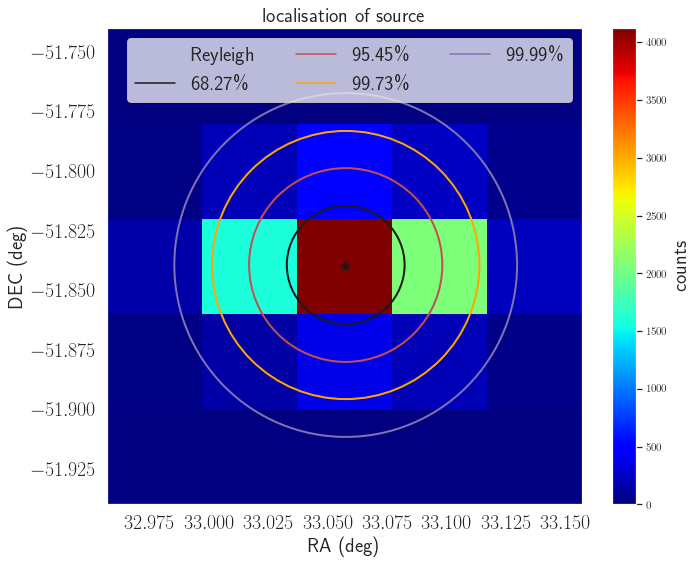


================ texp = 100s ==============

/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_100s.csv
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05646774573081 ra det std: 0.01220433564665176
~ dec det mean: -51.84063969033849 dec det std: 0.010092476883757482
~ pos det mean: 0.01183324266939043 pos det gamma: 0.008914990550636416


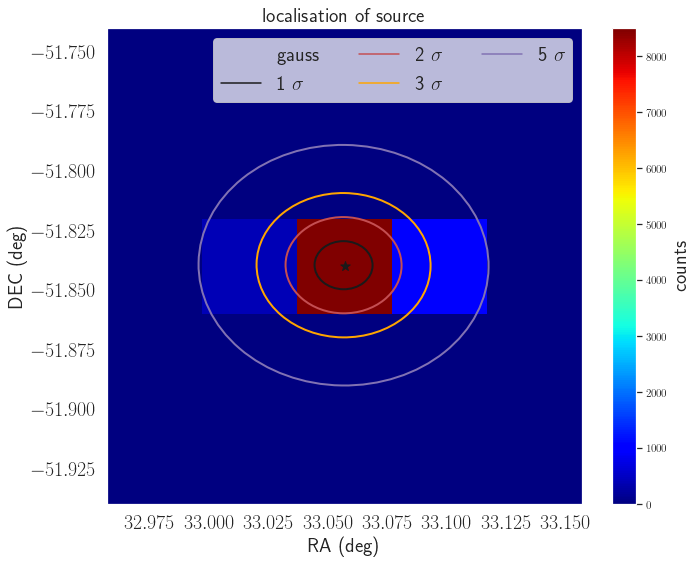

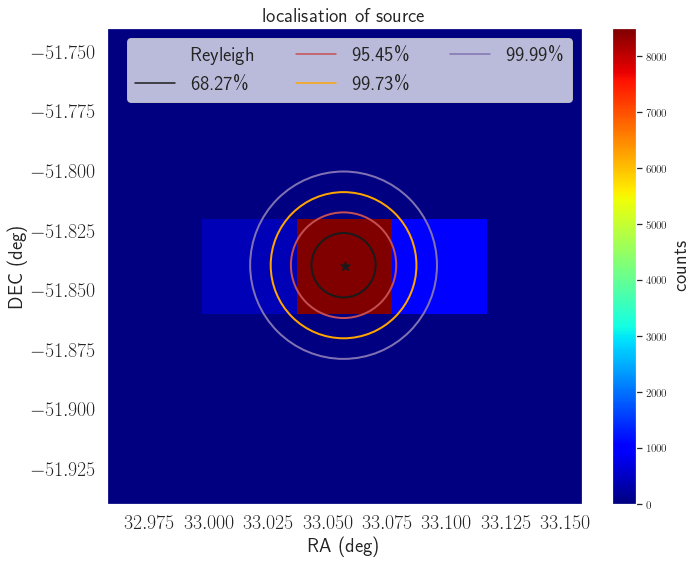

done plotting
done


In [56]:
# =======================
# !!! ALL TESXP PLOTS !!!
# =======================

png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/png/'
if not os.path.isdir(png_path):
    os.system('mkdir ' + png_path)

for index, f in enumerate(folders):
    print('\n' + f)
    path = directory + f + 'run0406/run0406_ID000126/csv/'
    png_path = directory + f + 'png/'
    if not os.path.isdir(png_path):
        os.mkdir(png_path)

    list_ra, list_dec, list_pos = ([] for j in range(3))
    list_mode_pos, list_mean_ra, list_mean_dec, list_mean_pos = ([] for j in range(4))
    list_std_ra, list_std_dec = ([] for j in range(2))
    
    for n in range(len(texp)) :  

        # store values ---!
        filename = csvMerged[n]
        print('\n================ texp = %ds ==============\n' %texp[n])
        print(path+filename)
        # load DataFrame and column names ---!
        df = pd.read_csv(path+filename)
        cols = list(df.columns)
        trials = len(df[cols[0]])
        print('* verify trials = ', trials)  
        # dropping ALL duplicte values 
        df.drop_duplicates(subset=cols[0], keep='last', inplace=False) 
        trials = len(df[cols[0]])
        print('* drop duplicate => trials = ', trials) 
        total = trials
        # drop NaN ---!
        df = df.dropna()
        trials = len(df[cols[0]])
        #df = df.reindex(np.arange(trials))
        print('* drop nan => trials = ', trials)  
        perc = 100 * (trials/total)
        print('! NaN DETECTION RATE :', 100-perc, '%')

        trial = np.array(df[cols[0]])
        raDet = np.array(df[cols[-2]])
        decDet = np.array(df[cols[-1]])

        perc = 100 * (trials/total)
        print('! DETECTION RATE :', perc, '%')

        # DETECTION ---!
        distance_det = []
        d_det = []
        ra_det = []
        dec_det = []

        for i in range(len(raDet)) :
            if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
                det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
                dist = float(true_coord.separation(det_coord).deg)
                distance_det.append(dist)                  

                if dist < threshold :
                    d_det.append(dist)
                    ra_det.append(raDet[i]) 
                    dec_det.append(decDet[i]) 

        perc_det = len(d_det)/total * 100
        print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

        # MEAN DET ---!
        mean_raDet = np.nanmean(ra_det)
        std_raDet = np.nanstd(ra_det)
        mean_decDet = np.nanmean(dec_det)
        std_decDet = np.nanstd(dec_det)
        mean_posDet = np.nanmean(d_det)

        tmp = 0
        for i in range(len(d_det)) :
            tmp += d_det[i]**2

        if len(d_det) != 0.0 :
            mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
            MLE_det = 0.606/mode_det
        else:
            mode_det = np.nan
            MLE_det = np.nan
            
        print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
        print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
        print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)
        
        # PLOT MAP 2D ---!
        mappage(ra_det, dec_det, mode_det, trueRA, trueDEC, texp[n])

        # SINGLE HIST ---!
        #plottage([texp[n]], [ra_det], [dec_det], [d_det], [mean_raDet], [mean_decDet], [mode_det], 
        #         trueRA, trueDEC, png_path+'texp%ds' %texp[n], hist=hist)
        
        
        #list_ra.append(ra_det)
        #list_dec.append(dec_det)
        #list_pos.append(d_det)
        #list_mean_ra.append(mean_raDet)
        #list_mean_dec.append(mean_decDet)
        #list_mean_pos.append(mean_posDet)
        #list_std_ra.append(std_raDet)
        #list_std_dec.append(std_decDet)
        #list_mode_pos.append(mode_det)

    # PLOT HIST GATHERED BY TEXP ---!
    #plottage(texp, list_ra, list_dec, list_pos, list_std_ra, list_std_dec, list_mode_pos, 
    #         trueRA, trueDEC, png_path+'alltexp', ltexp=True, hist=hist)
    
    print('done plotting')
print('done')


================ texp = 1s ==============

tesi_preliminary_nominal_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_1s.csv
tesi_preliminary_nominal_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_1s.csv
tesi_preliminary_degraded_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_1s.csv
tesi_preliminary_degraded_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_1s.csv


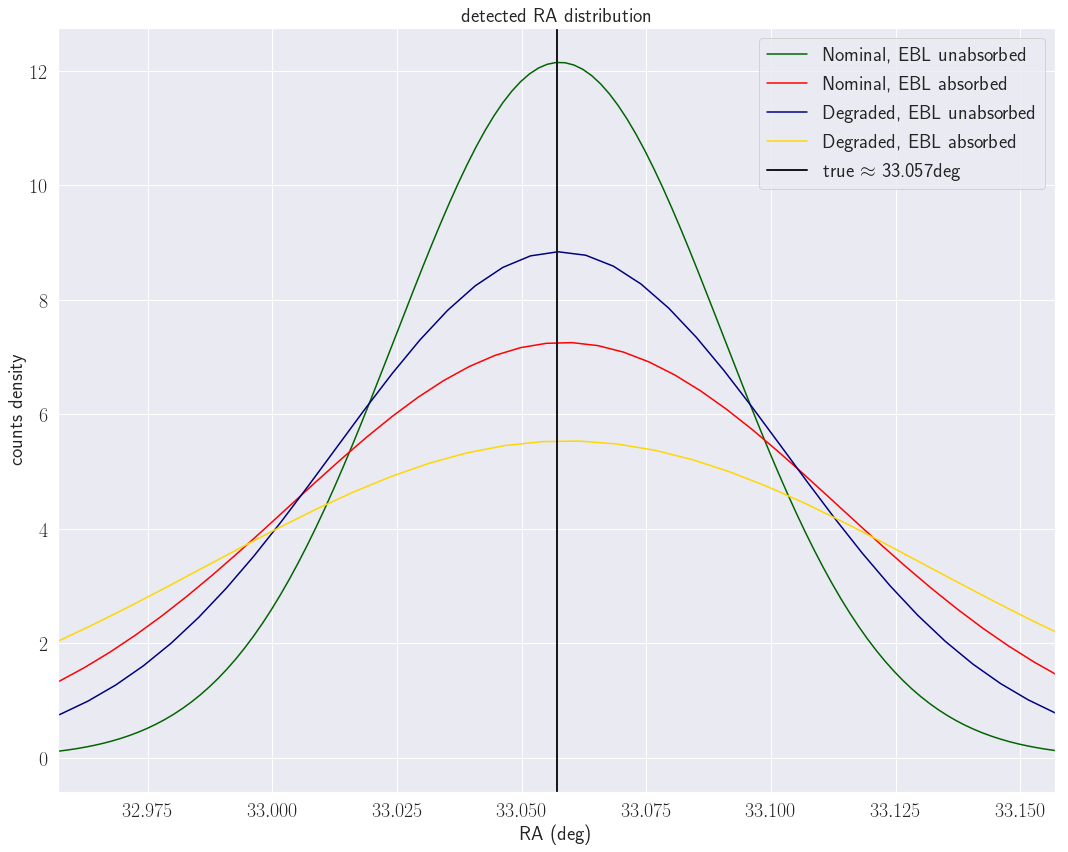

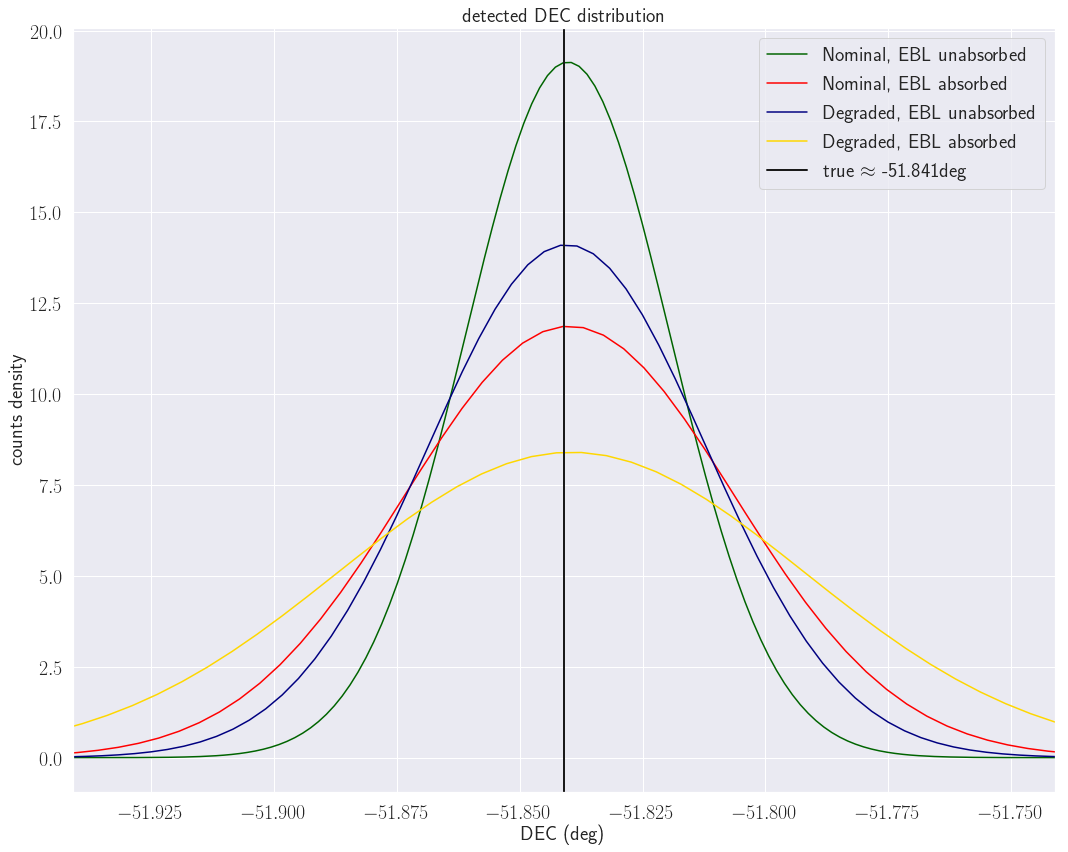

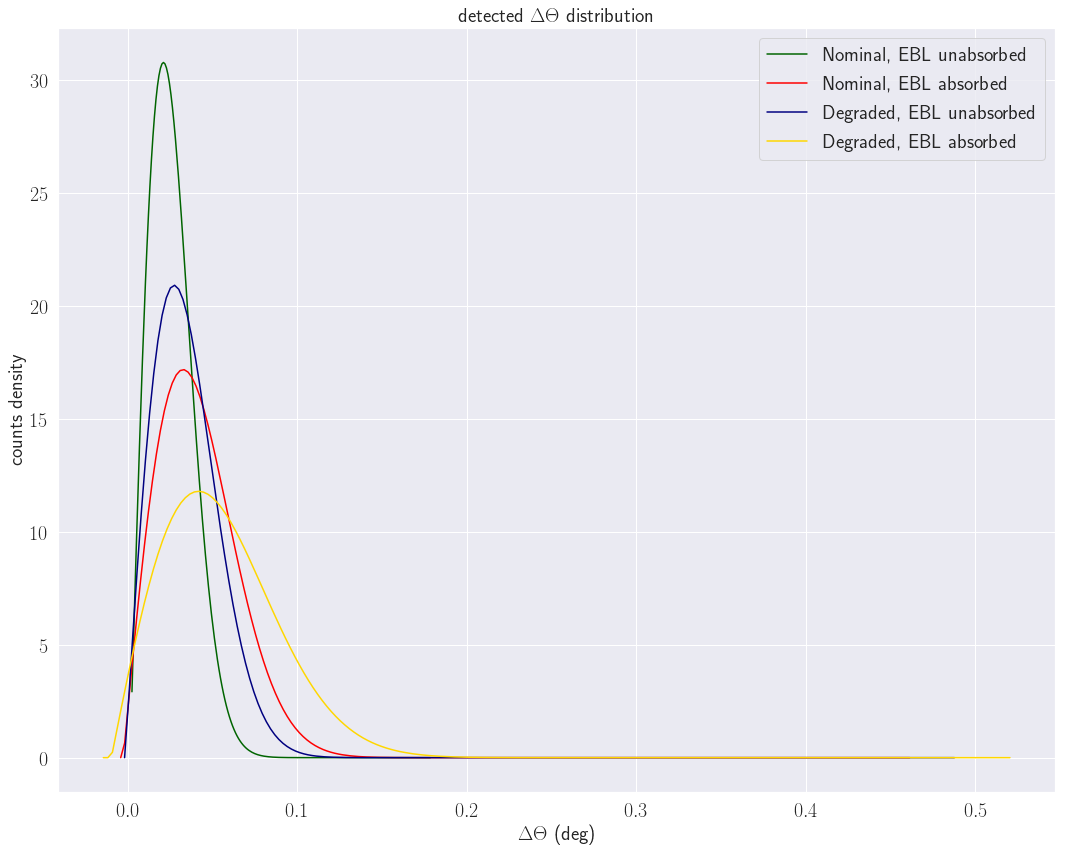

done plotting

================ texp = 5s ==============

tesi_preliminary_nominal_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_5s.csv
tesi_preliminary_nominal_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_5s.csv
tesi_preliminary_degraded_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_5s.csv
tesi_preliminary_degraded_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_5s.csv


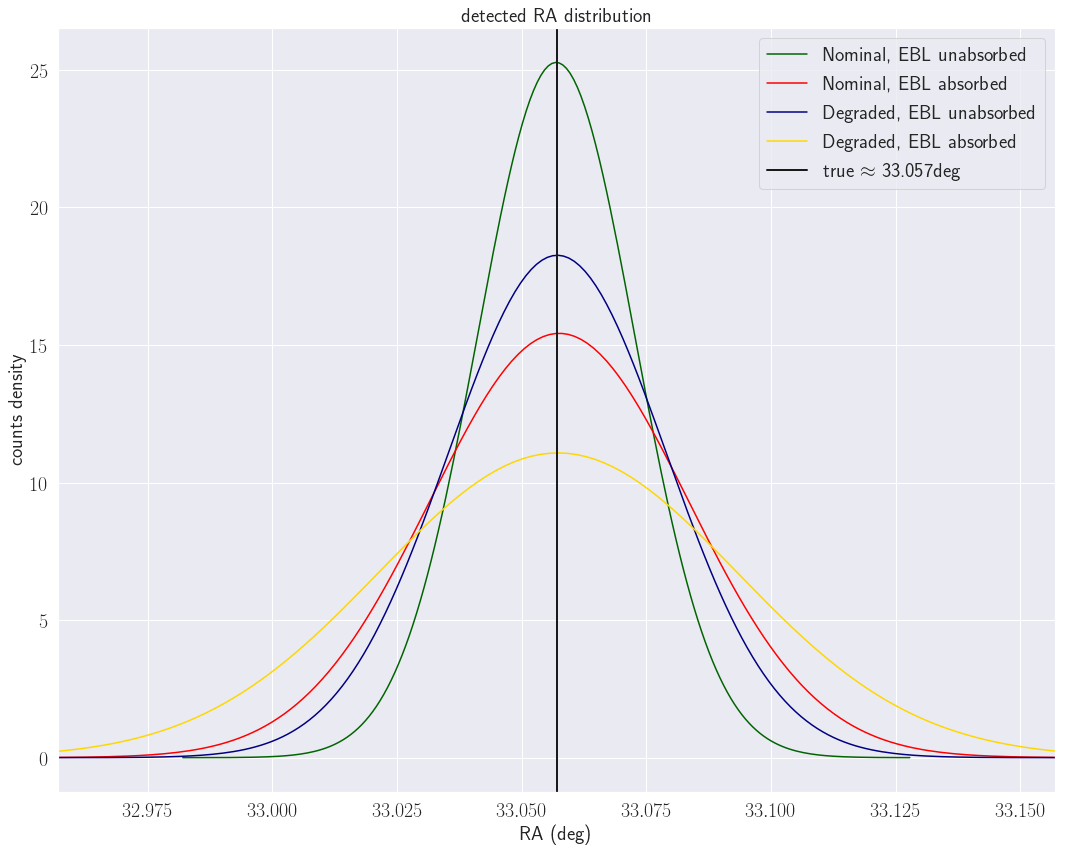

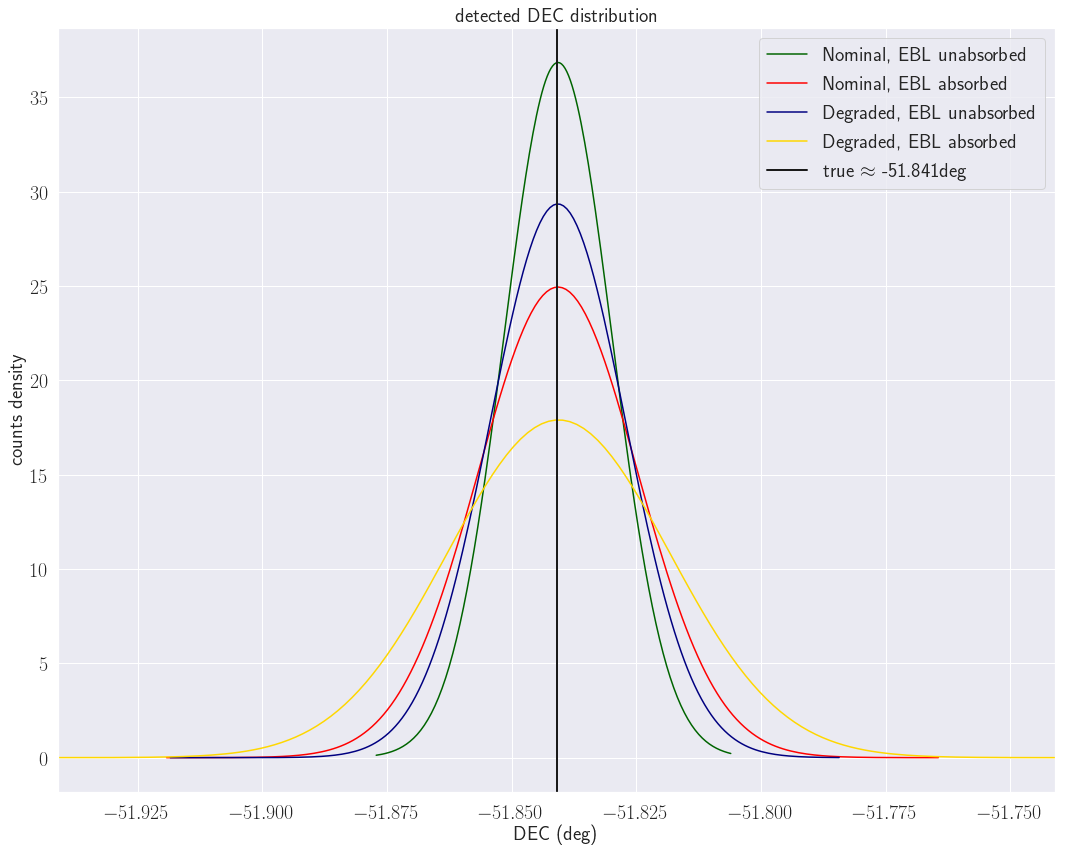

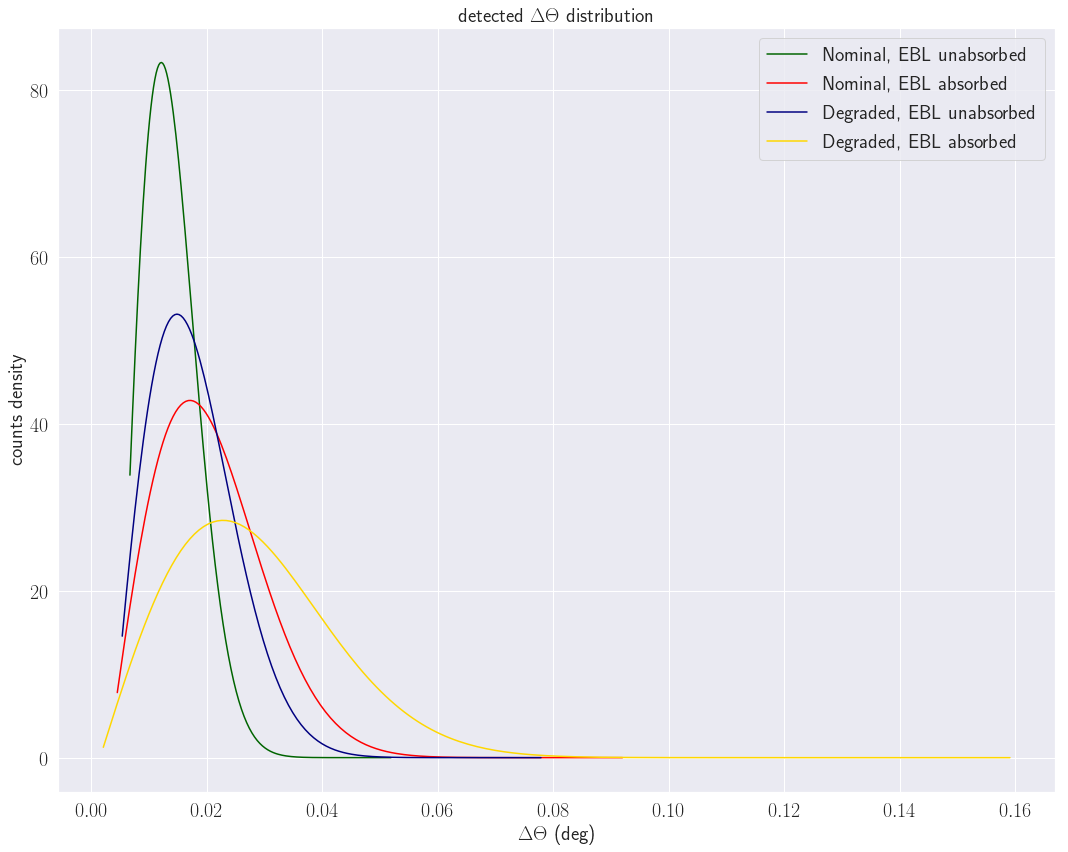

done plotting

================ texp = 10s ==============

tesi_preliminary_nominal_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_10s.csv
tesi_preliminary_nominal_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_10s.csv
tesi_preliminary_degraded_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_10s.csv
tesi_preliminary_degraded_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_10s.csv


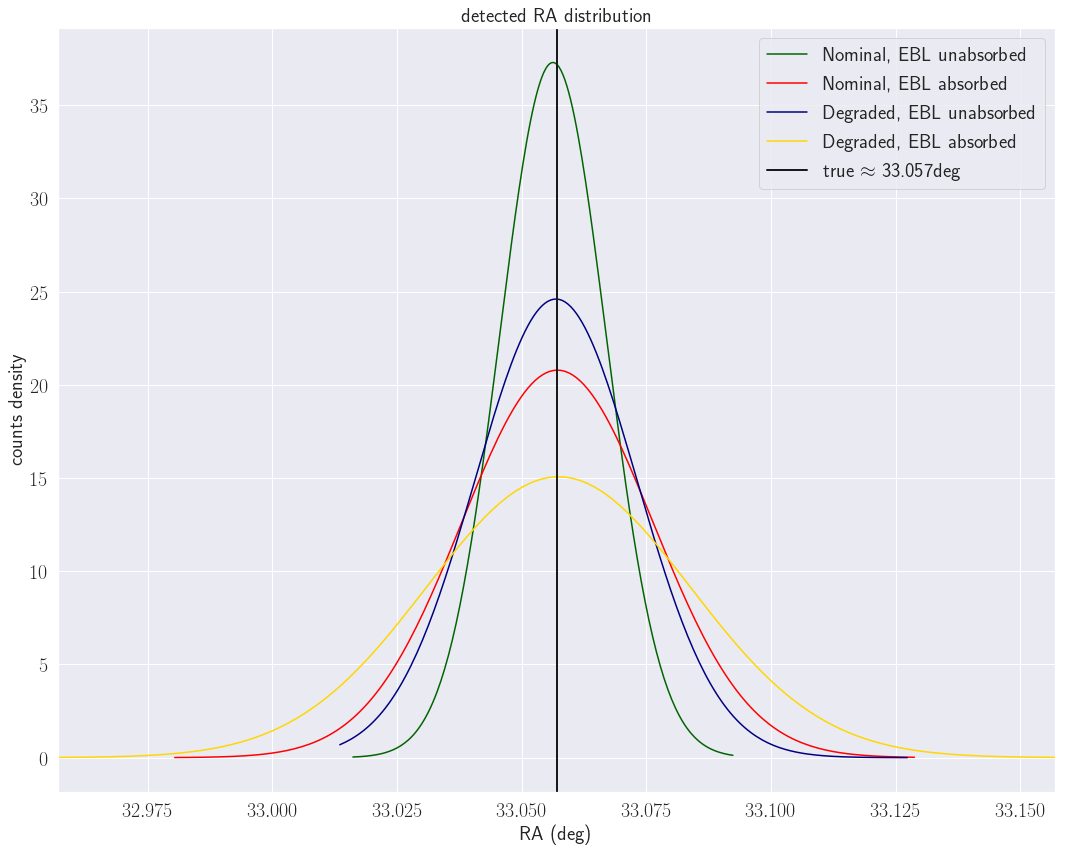

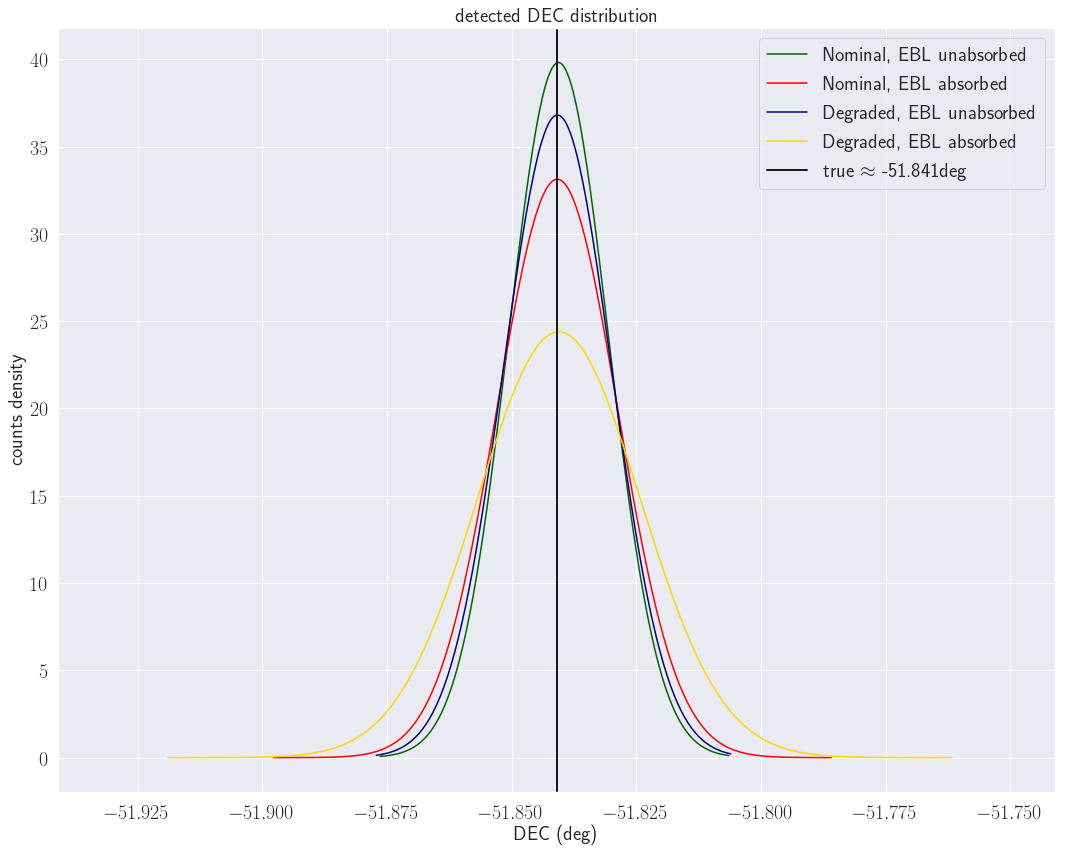

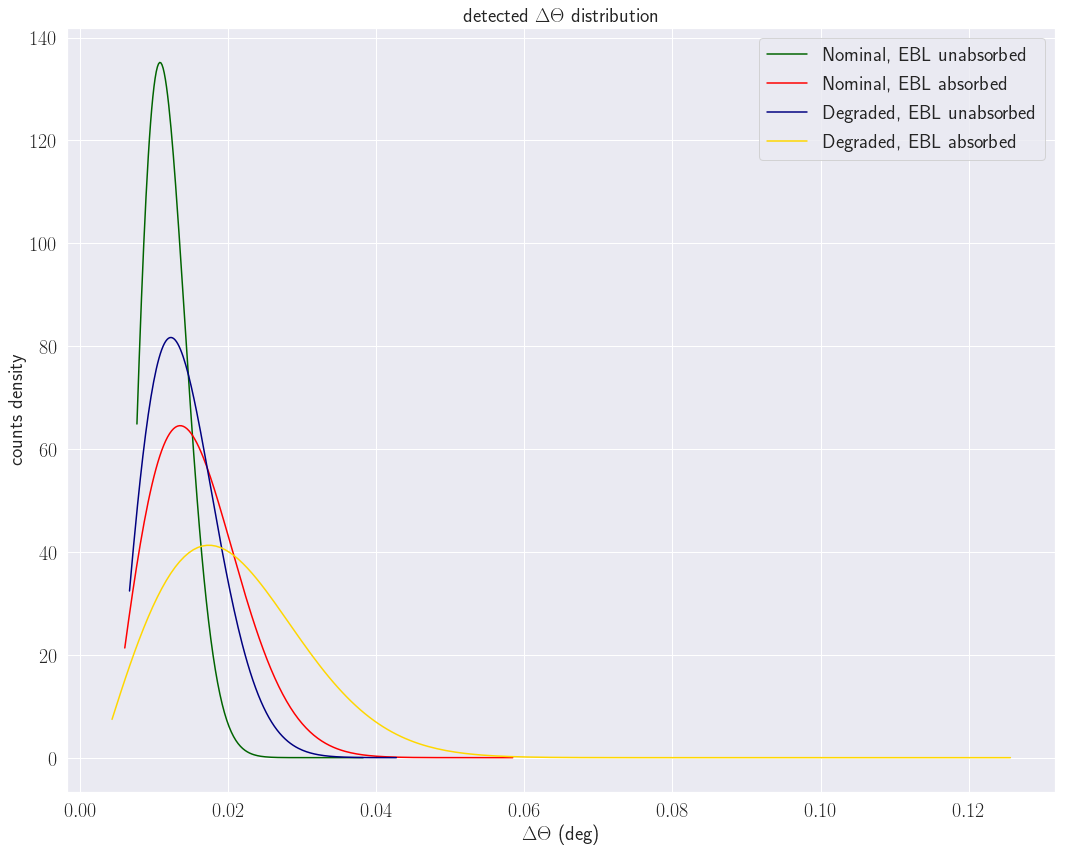

done plotting

================ texp = 100s ==============

tesi_preliminary_nominal_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_noEBL/run0406/run0406_ID000126/csv/run0406_100s.csv
tesi_preliminary_nominal_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_nominal_EBL/run0406/run0406_ID000126/csv/run0406_100s.csv
tesi_preliminary_degraded_noEBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_noEBL/run0406/run0406_ID000126/csv/run0406_100s.csv
tesi_preliminary_degraded_EBL/
/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/tesi_preliminary_degraded_EBL/run0406/run0406_ID000126/csv/run0406_100s.csv


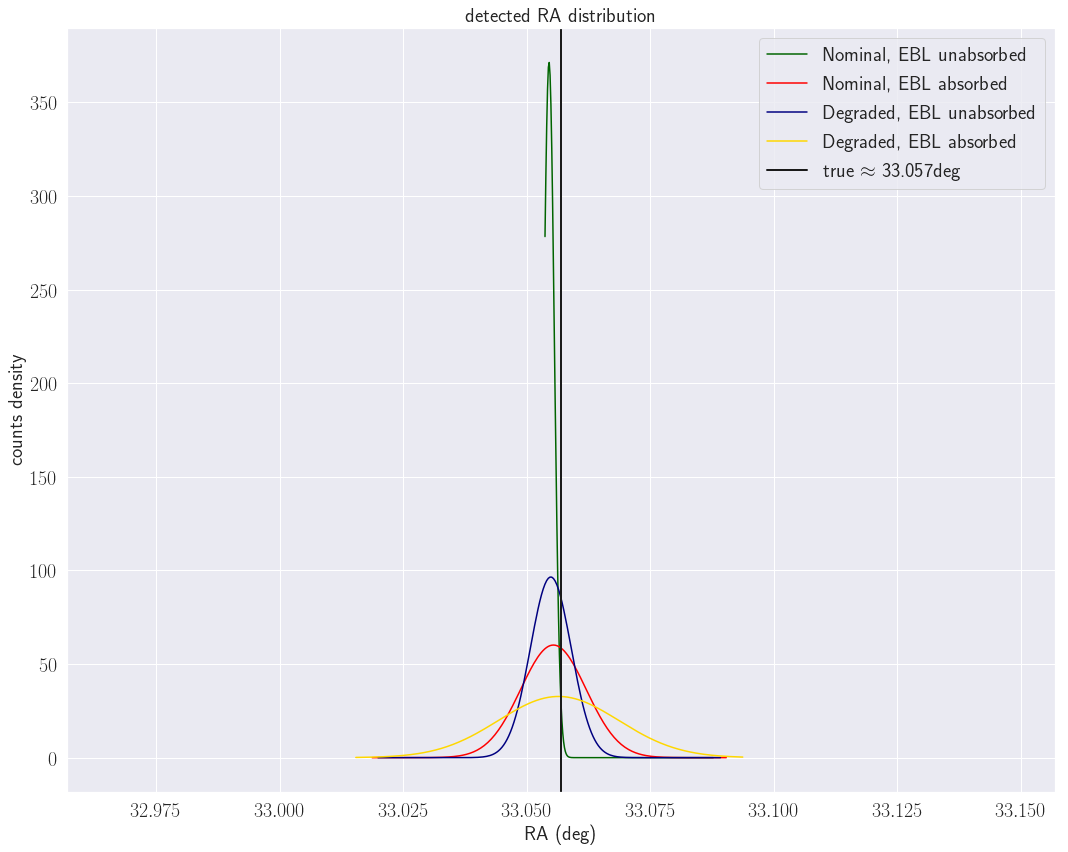

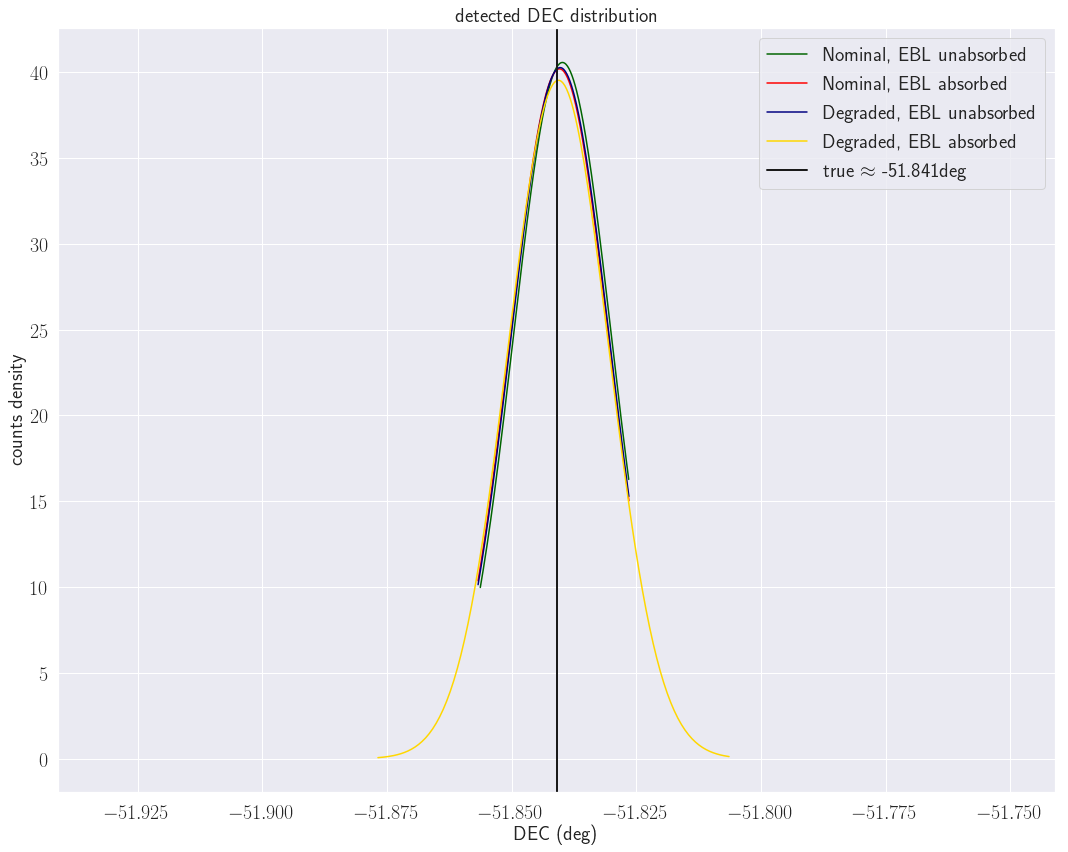

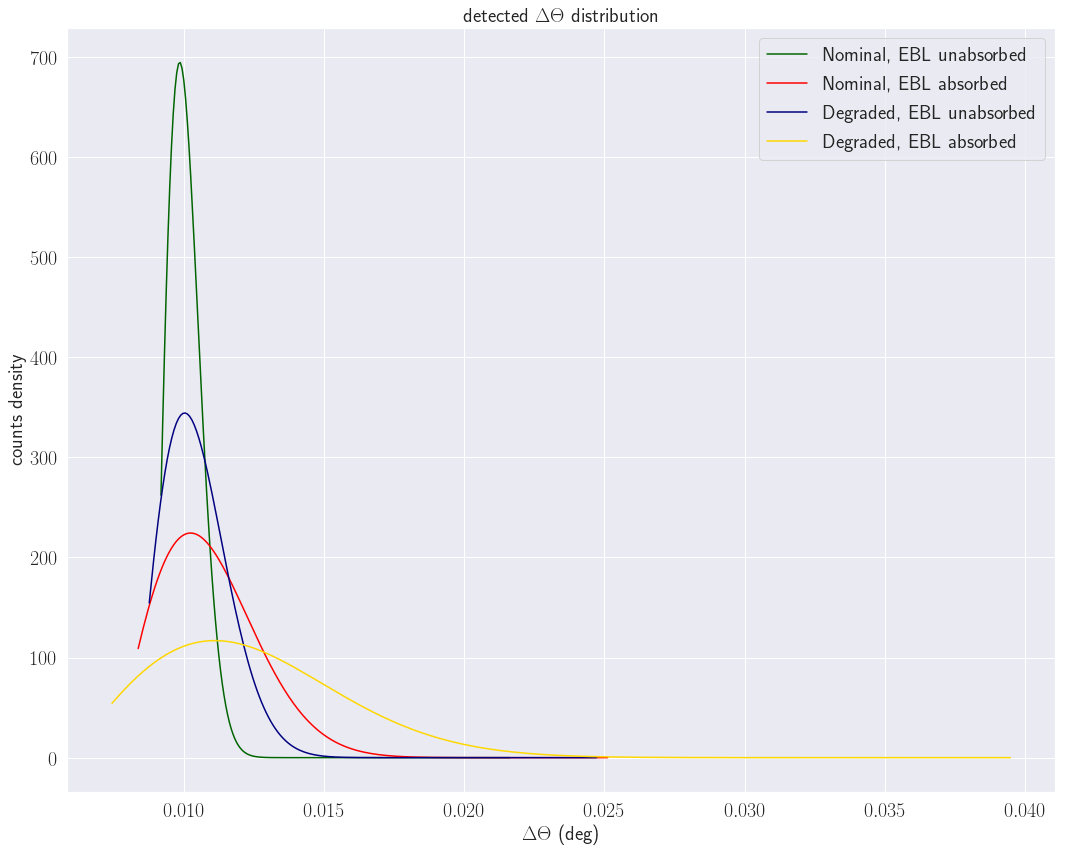

done plotting
done


In [30]:
# ============================
# !!! CHOICE CONFRONTATION !!!
# ============================
png_path = directory + 'png/'

for n in range(len(texp)) :  
    print('\n================ texp = %ds ==============\n' %texp[n])

    list_ra, list_dec, list_pos = ([] for j in range(3))
    list_mode_pos, list_mean_ra, list_mean_dec, list_mean_pos = ([] for j in range(4))
    list_std_ra, list_std_dec = ([] for j in range(2))
    
    for index, f in enumerate(folders):

        # store values ---!
        print(f)
        path = directory + f + 'run0406/run0406_ID000126/csv/'
        filename = csvMerged[n]
        print(path+filename)

        # load DataFrame and column names ---!
        df = pd.read_csv(path+filename)
        cols = list(df.columns)
        trials = len(df[cols[0]])
        # dropping ALL duplicte values 
        df.drop_duplicates(subset=cols[0], keep='last', inplace=False) 
        trials = len(df[cols[0]])
        total = trials
        # drop NaN ---!
        df = df.dropna()
        trials = len(df[cols[0]])
        #df = df.reindex(np.arange(trials))
        perc = 100 * (trials/total)

        trial = np.array(df[cols[0]])
        raDet = np.array(df[cols[-2]])
        decDet = np.array(df[cols[-1]])

        # DETECTION ---!
        distance_det = []
        d_det = []
        ra_det = []
        dec_det = []

        for i in range(len(raDet)) :
            if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
                det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
                dist = float(true_coord.separation(det_coord).deg)
                distance_det.append(dist)                  

                if dist < threshold :
                    d_det.append(dist)
                    ra_det.append(raDet[i]) 
                    dec_det.append(decDet[i]) 

        # MEAN DET ---!
        mean_raDet = np.nanmean(ra_det)
        std_raDet = np.nanstd(ra_det)
        mean_decDet = np.nanmean(dec_det)
        std_decDet = np.nanstd(dec_det)
        mean_posDet = np.nanmean(d_det)

        tmp = 0
        for i in range(len(d_det)) :
            tmp += d_det[i]**2

        if len(d_det) != 0.0 :
            mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
            MLE_det = 0.606/mode_det
        else:
            mode_det = np.nan
            MLE_det = np.nan

        list_ra.append(ra_det)
        list_dec.append(dec_det)
        list_pos.append(d_det)
        list_mean_ra.append(mean_raDet)
        list_mean_dec.append(mean_decDet)
        list_mean_pos.append(mean_posDet)
        list_std_ra.append(std_raDet)
        list_std_dec.append(std_decDet)
        list_mode_pos.append(mode_det)

    # PLOT HIST GATHERED BY TEXP ---!
    plottage(texp, list_ra, list_dec, list_pos, list_std_ra, list_std_dec, list_mode_pos, 
             trueRA, trueDEC, png_path+'all_texp%ds' %texp[n], ltexp=False, hist=False)
    print('done plotting')
print('done')